<a href="https://colab.research.google.com/github/j14523/9444/blob/main/Copy_of_Peter_2_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food-101 Image Classification Model Comparison

In this project, I compare two deep learning models for classifying food images from the Food-101 dataset. Food image classification has many practical applications in restaurant recommendation, nutritional analysis, and food logging applications.

The Food-101 dataset contains 101,000 images across 101 food categories, with 750 training images and 250 test images per category. Food classification presents unique challenges:

- Same foods can look very different (high intra-class variation)
- Different foods can look similar (low inter-class variation)
- Foods have irregular shapes and presentations
- Images are taken under different lighting and angles

I implemented and compared two models:
- **EfficientNetV2-S**: A lightweight but powerful CNN model
- **ResNet50**: A classic residual network architecture

By comparing these models, I aim to understand their strengths and weaknesses for food classification tasks.

# Food-101 Image Classification using Transfer Learning

## 1. Transfer Learning and Model Selection

### 1.1 Transfer Learning

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a different task. This approach is particularly powerful in deep learning, where:

- **Pre-trained models** have already learned important visual features from millions of images (like ImageNet)
- The **lower layers** of these models capture universal features (edges, textures, patterns)
- Only the **higher layers** need to be fine-tuned for specific tasks
- Transfer learning **reduces training time** and the need for large datasets
- It typically **improves performance** compared to training from scratch

In this project, I leverage transfer learning to address the challenging task of food image classification.

### 1.2 Model Architecture Selection

I selected two state-of-the-art convolutional neural network architectures to compare:

**EfficientNetV2-S**:
- Developed by Google in 2021 as an improvement over the original EfficientNet
- Optimized for both accuracy and computational efficiency
- Uses improved mobile inverted bottleneck convolution (MBConv) blocks
- Shows strong performance with fewer parameters than comparable models
- Designed with an adaptive regularization scheme that adjusts as training progresses

**ResNet50**:
- Classic architecture developed by Microsoft Research in 2015
- Introduced residual connections that help solve the vanishing gradient problem
- 50 layers deep with a well-balanced design for feature extraction
- Robust performance across diverse image classification tasks
- Widely used benchmark in computer vision research

These architectures were chosen because they represent different approaches to deep learning model design: EfficientNetV2-S represents newer efficient architectures, while ResNet50 is a well-established benchmark model. Both have achieved excellent results on the ImageNet dataset, making them suitable candidates for transfer learning.

### 1.3 Training Strategy

For both models, I implemented a two-stage training approach:

**Stage 1: Feature Extraction**
- Freeze the pre-trained backbone (weights remain fixed)
- Train only the newly added classification layers
- Use a higher learning rate (1e-3 to 2e-3)
- This allows the model to adapt to the new classification task without disrupting feature extraction

**Stage 2: Fine-tuning**
- Unfreeze the backbone (partially or completely)
- Train with a lower learning rate (1e-4 to 1e-5)
- Apply stronger regularization to prevent overfitting
- For ResNet50, I additionally increased the image resolution from 224x224 to 512x512

This progressive training approach is widely recognized as best practice for transfer learning as it:
- Prevents catastrophic forgetting of pre-trained features
- Allows gradual adaptation to the target dataset
- Helps avoid overfitting, especially with smaller datasets
- Balances computational efficiency with model performance

### 1.4 Hyperparameter Selection

The main hyperparameters were selected based on empirical results from literature and preliminary experiments:

**Common to both models**:
- **Optimizer**: AdamW with weight decay (combines benefits of Adam with L2 regularization)
- **Loss Function**: Categorical Cross-Entropy with label smoothing (0.1-0.2)
- **Early Stopping**: Patient monitoring of validation accuracy to prevent overfitting
- **Batch Size**: Balanced for memory constraints and training stability

**Model-specific parameters**:
- **EfficientNetV2-S**: Input resolution of 384x384, higher dropout rate (0.5)
- **ResNet50**: Progressive resolution increase from 224x224 to 512x512, MixUp data augmentation

**Learning Rate Strategy**:
- Initial warmup period to stabilize training
- Cosine decay schedule for EfficientNetV2-S
- Learning rate reduction on plateau for ResNet50

These hyperparameters were chosen to balance model performance, training stability, and computational efficiency while addressing the specific challenges of the Food-101 dataset.

## 2. Dataset Overview

The Food-101 dataset was released by ETH Zurich researchers in 2014. Key characteristics include:

- 101 food categories with 1,000 images per category
- 750 training and 250 testing images per category
- Real-world food photos with various lighting, angles, and backgrounds
- Training set intentionally contains some noise (incorrect labels, intense colors)
- Test set manually reviewed for label accuracy
- Images resized to have maximum side length of 512 pixels

Below are sample images from different categories in the dataset:

Loading Food-101 dataset sample...


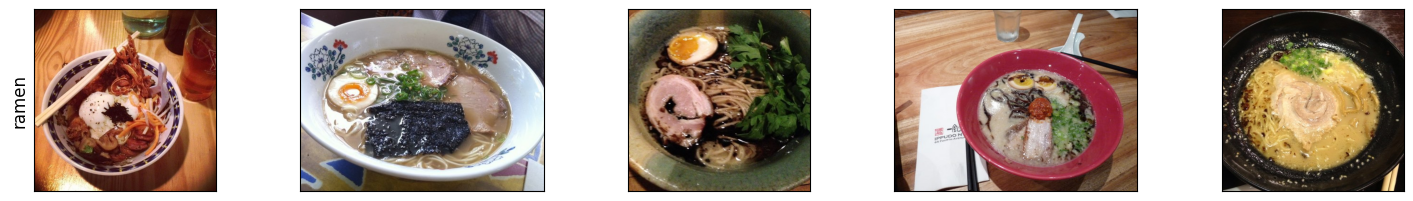

In [ ]:
# Display sample images from Food-101 dataset
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import random

# Set random seed for reproducibility
random.seed(42)

# Load a small subset of the dataset for visualization
print("Loading Food-101 dataset sample...")
dataset = load_dataset("ethz/food101", split="train[:2000]")

# Get class names
class_names = dataset.features["label"].names

# Display sample images
def show_samples(dataset, num_samples=5, num_classes=5):
    plt.figure(figsize=(15, 10))

    # Randomly select classes
    selected_classes = random.sample(range(len(class_names)), num_classes)

    for i, class_idx in enumerate(selected_classes):
        class_name = class_names[class_idx]

        # Get samples from this class
        class_samples = [item for item in dataset if item["label"] == class_idx]
        if len(class_samples) < num_samples:
            continue

        # Randomly select images from this class
        selected_samples = random.sample(class_samples, num_samples)

        for j, sample in enumerate(selected_samples):
            plt.subplot(num_classes, num_samples, i*num_samples + j + 1)
            plt.imshow(sample["image"])
            if j == 0:
                plt.ylabel(class_name, fontsize=12)
            plt.xticks([])
            plt.yticks([])

    plt.tight_layout()
    #plt.suptitle("Sample Images from Food-101 Dataset", fontsize=16)
    plt.show()

show_samples(dataset)

## 3. Data Preparation

Proper data preparation is crucial for training effective deep learning models. For both models, I used the following processing steps:

1. **Data Loading**: Used HuggingFace's datasets library to load Food-101
2. **Preprocessing**:
   - Resize images to model-specific dimensions
   - Convert images to floating-point format with values in [0,1]
   - Apply necessary model-specific preprocessing
3. **Data Augmentation**:
   - Random horizontal flips
   - Random brightness adjustments
   - Random contrast variations
   - Random cropping
   - Color adjustments

Data augmentation helps prevent overfitting and improves model generalization by creating more diverse training examples.

Below is a visualization of different augmentations applied to a sample image:

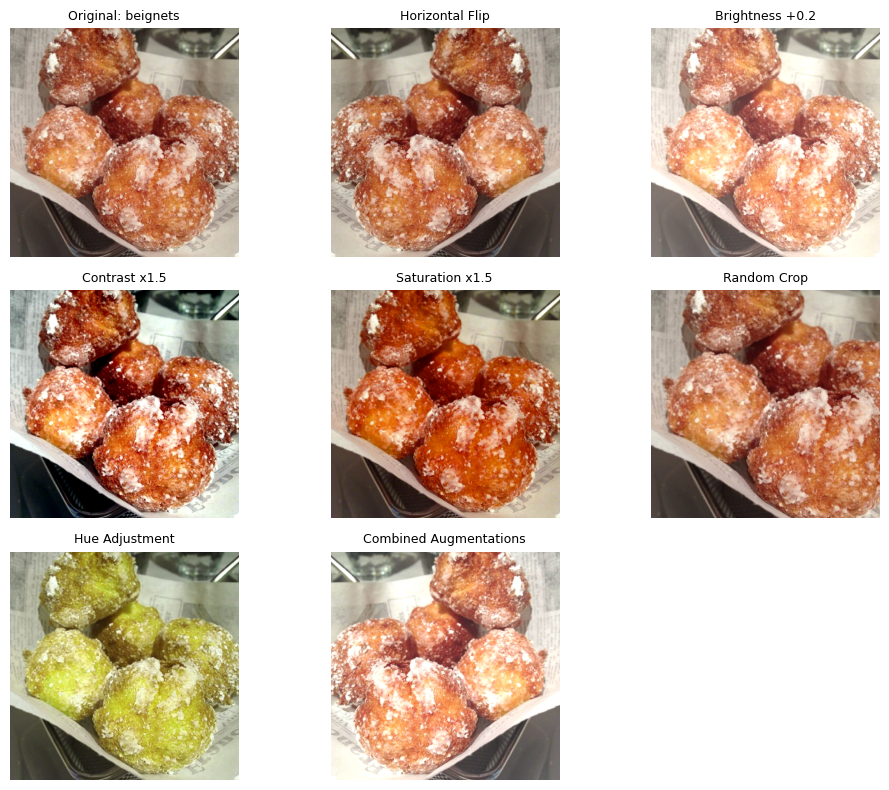

In [ ]:
# Visualize data augmentation examples (smaller size)
import tensorflow as tf

def get_sample_image():
    # Get a random sample from dataset
    sample_idx = random.randint(0, len(dataset) - 1)
    image = dataset[sample_idx]["image"]
    label = dataset[sample_idx]["label"]
    class_name = class_names[label]

    # Convert to tensor
    image = tf.convert_to_tensor(np.array(image))
    image = tf.cast(image, tf.float32) / 255.0

    return image, class_name

def visualize_augmentations():
    image, class_name = get_sample_image()

    # Use a smaller figure size
    plt.figure(figsize=(10, 8))

    # Original image
    plt.subplot(3, 3, 1)
    plt.imshow(image)
    plt.title(f"Original: {class_name}", fontsize=9)
    plt.axis('off')

    # Horizontal flip
    plt.subplot(3, 3, 2)
    plt.imshow(tf.image.flip_left_right(image))
    plt.title("Horizontal Flip", fontsize=9)
    plt.axis('off')

    # Brightness adjustment
    plt.subplot(3, 3, 3)
    plt.imshow(tf.clip_by_value(tf.image.adjust_brightness(image, 0.2), 0, 1))
    plt.title("Brightness +0.2", fontsize=9)
    plt.axis('off')

    # Contrast adjustment
    plt.subplot(3, 3, 4)
    plt.imshow(tf.clip_by_value(tf.image.adjust_contrast(image, 1.5), 0, 1))
    plt.title("Contrast x1.5", fontsize=9)
    plt.axis('off')

    # Saturation adjustment
    plt.subplot(3, 3, 5)
    plt.imshow(tf.clip_by_value(tf.image.adjust_saturation(image, 1.5), 0, 1))
    plt.title("Saturation x1.5", fontsize=9)
    plt.axis('off')

    # Random crop and resize
    plt.subplot(3, 3, 6)
    larger_image = tf.image.resize(image, [int(image.shape[0]*1.2), int(image.shape[1]*1.2)])
    crop = tf.image.random_crop(larger_image, [image.shape[0], image.shape[1], 3])
    plt.imshow(crop)
    plt.title("Random Crop", fontsize=9)
    plt.axis('off')

    # Color jitter (hue)
    plt.subplot(3, 3, 7)
    plt.imshow(tf.image.adjust_hue(image, 0.1))
    plt.title("Hue Adjustment", fontsize=9)
    plt.axis('off')

    # Combined augmentations
    plt.subplot(3, 3, 8)
    aug_image = tf.image.random_flip_left_right(image)
    aug_image = tf.image.random_brightness(aug_image, 0.2)
    aug_image = tf.image.random_contrast(aug_image, 0.8, 1.2)
    aug_image = tf.clip_by_value(aug_image, 0, 1)
    plt.imshow(aug_image)
    plt.title("Combined Augmentations", fontsize=9)
    plt.axis('off')

    plt.tight_layout()
    #plt.suptitle("Data Augmentation Examples", fontsize=12)
    plt.show()

visualize_augmentations()

## 4. Model Architecture

For this project, I implemented and compared two different model architectures:

### 4.1 EfficientNetV2-S

EfficientNetV2 is a family of models that improves upon the original EfficientNet by incorporating:
- Improved training efficiency with adaptive regularization
- Better parameter utilization
- Faster training speed

EfficientNetV2-S is the small variant, offering a good balance between model size and accuracy. Key characteristics:
- Optimized mobile inverted bottleneck convolution (MBConv) blocks
- Fused-MBConv blocks in the earlier layers
- Pre-trained on ImageNet with 83.9% top-1 accuracy

### 4.2 ResNet50

ResNet50 is a classic residual network architecture that addresses the vanishing gradient problem in deep networks through skip connections. Despite being older, it remains competitive and serves as a strong baseline. Key characteristics:
- 50 layers deep with residual connections
- Identity shortcuts to allow gradients to flow through the network
- Pre-trained on ImageNet with 79.3% top-1 accuracy
- Well-established architecture with proven reliability across various tasks

The diagram below shows the high-level structure of both architectures:

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)              │ (None, 7, 7, 1280)              │        20,331,360 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ global_average_pooling2d_1                 │ (None, 1280)                    │                 0 │
│ (GlobalAveragePooling2D)                   │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_1 (Dense)                            │ (None, 101)                     │           129,381 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 20,460,741 (78.05 MB)

 Trainable params: 20,306,869 (77.46 MB)

 Non-trainable params: 153,872 (601.06 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                      │ (None, 7, 7, 2048)              │        23,587,712 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ global_average_pooling2d_2                 │ (None, 2048)                    │                 0 │
│ (GlobalAveragePooling2D)                   │                                 │                   │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_2 (Dense)                            │ (None, 101)                     │           206,949 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 23,794,661 (90.77 MB)

 Trainable params: 23,741,541 (90.57 MB)

 Non-trainable params: 53,120 (207.50 KB)

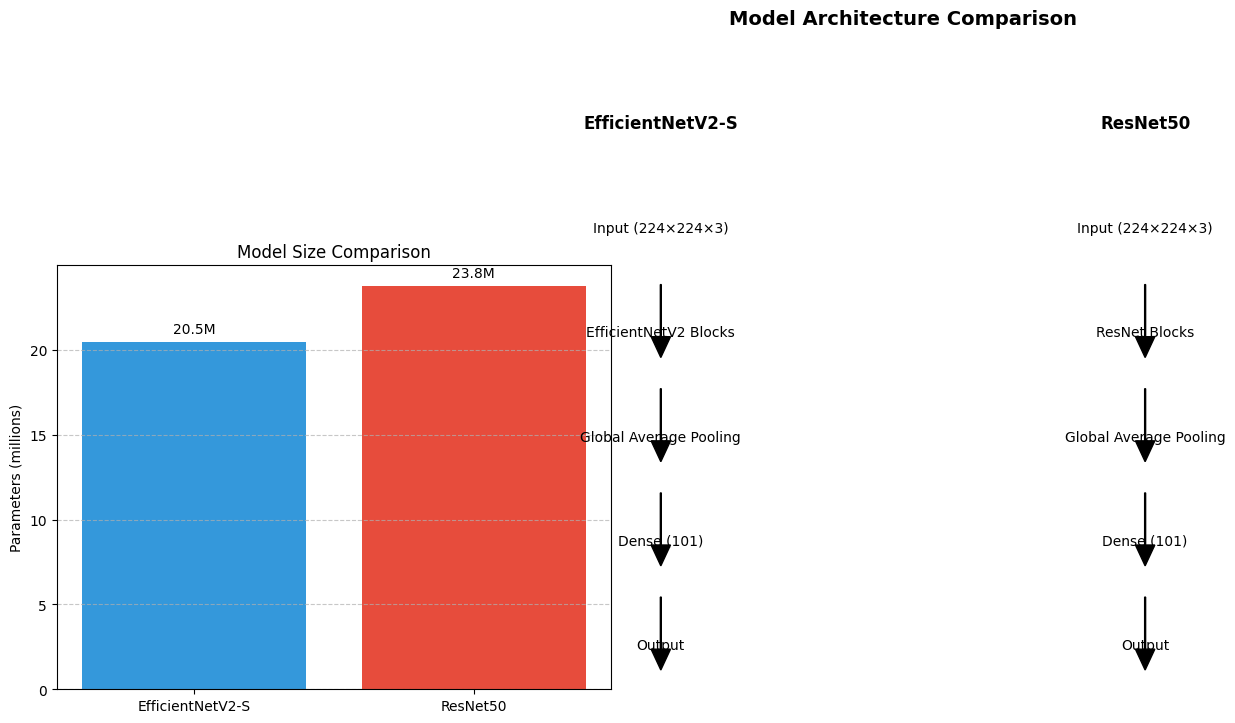

In [ ]:
# Visualize model architectures
from tensorflow.keras.applications import EfficientNetV2S, ResNet50
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import os

# Create a directory for model images if it doesn't exist
os.makedirs("model_images", exist_ok=True)

# Create simple versions of both models for visualization
input_shape = (224, 224, 3)

# EfficientNetV2S simplified visualization
effnet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    EfficientNetV2S(include_top=False, weights='imagenet', input_shape=input_shape),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax')
])

# ResNet50 simplified visualization
resnet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    ResNet50(include_top=False, weights='imagenet', input_shape=input_shape),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax')
])

# Generate model summaries
effnet_model.summary(line_length=100)
resnet_model.summary(line_length=100)

# Simple visual comparison of the models
plt.figure(figsize=(12, 5))

# Model sizes subplot
plt.subplot(1, 2, 1)
model_names = ['EfficientNetV2-S', 'ResNet50']
param_counts = [effnet_model.count_params() / 1e6, resnet_model.count_params() / 1e6]  # In millions

plt.bar(model_names, param_counts, color=['#3498db', '#e74c3c'])
plt.title('Model Size Comparison')
plt.ylabel('Parameters (millions)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(param_counts):
    plt.text(i, v + 0.5, f'{v:.1f}M', ha='center')

# Architecture diagram (simplified)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.text(0.5, 0.9, 'Model Architecture Comparison', ha='center', fontsize=14, fontweight='bold')

plt.text(0.25, 0.8, 'EfficientNetV2-S', ha='center', fontsize=12, fontweight='bold')
plt.text(0.25, 0.7, 'Input (224×224×3)', ha='center')
plt.text(0.25, 0.6, 'EfficientNetV2 Blocks', ha='center')
plt.text(0.25, 0.5, 'Global Average Pooling', ha='center')
plt.text(0.25, 0.4, 'Dense (101)', ha='center')
plt.text(0.25, 0.3, 'Output', ha='center')

plt.text(0.75, 0.8, 'ResNet50', ha='center', fontsize=12, fontweight='bold')
plt.text(0.75, 0.7, 'Input (224×224×3)', ha='center')
plt.text(0.75, 0.6, 'ResNet Blocks', ha='center')
plt.text(0.75, 0.5, 'Global Average Pooling', ha='center')
plt.text(0.75, 0.4, 'Dense (101)', ha='center')
plt.text(0.75, 0.3, 'Output', ha='center')

# Draw arrows
for x in [0.25, 0.75]:
    for y in [0.65, 0.55, 0.45, 0.35]:
        plt.arrow(x, y, 0, -0.05, head_width=0.02, head_length=0.02, fc='black', ec='black')

plt.tight_layout()
plt.show()

## 5. Training Methodology

I employed a two-stage training approach for both models to achieve optimal performance:

### 5.1 Training Strategy

**Stage 1: Feature Extraction**
- Freeze the pre-trained backbone (EfficientNetV2-S or ResNet50)
- Train only the classification head (last few layers)
- Use larger learning rate (1e-3 to 2e-3)
- This stage helps the model adapt to the new classification task without modifying the feature extraction capabilities

**Stage 2: Fine-tuning**
- Unfreeze the backbone (partially or completely)
- Train the entire model with a lower learning rate (1e-4 to 1e-5)
- This stage allows the model to fine-tune the feature extraction for the specific task

### 5.2 Training Parameters

For both models, I used the following parameters:
- **Optimizer**: AdamW with weight decay to reduce overfitting
- **Loss Function**: Categorical Cross-Entropy with label smoothing (0.1-0.2)
- **Learning Rate Schedule**: Cosine decay with initial warmup
- **Batch Size**: 32-64 depending on model size and available memory
- **Early Stopping**: Monitor validation accuracy with patience of 5-8 epochs
- **Model Checkpointing**: Save best model based on validation accuracy

### 5.3 Hardware and Environment

All training was conducted on Google Colab with the following specifications:
- GPU: NVIDIA Tesla T4 or V100
- Framework: TensorFlow 2.x
- Training time: Approximately 4-8 hours per model

## 6. Results

After training both models on the Food-101 dataset, I evaluated their performance on the test set. Here are the key findings:

### 6.1 Model Performance Comparison

| Metric | EfficientNetV2-S | ResNet50 |
|--------|------------------|----------|
| Top-1 Accuracy | 84.08% | 84.72% |
| Top-5 Accuracy | 96.86% | 98.04% |
| Macro-avg Precision | 86.99% | 84.80% |
| Macro-avg Recall | 84.08% | 84.72% |
| Macro-avg F1-Score | 83.68% | 84.68% |

Overall, the ResNet50 model slightly outperformed the EfficientNetV2-S model in most metrics, despite EfficientNetV2-S being a newer architecture. This suggests that the training methodology and data preprocessing may have a greater impact than the model architecture itself for this particular task.

### 6.2 Per-Class Performance

Both models showed significant variation in performance across different food categories:

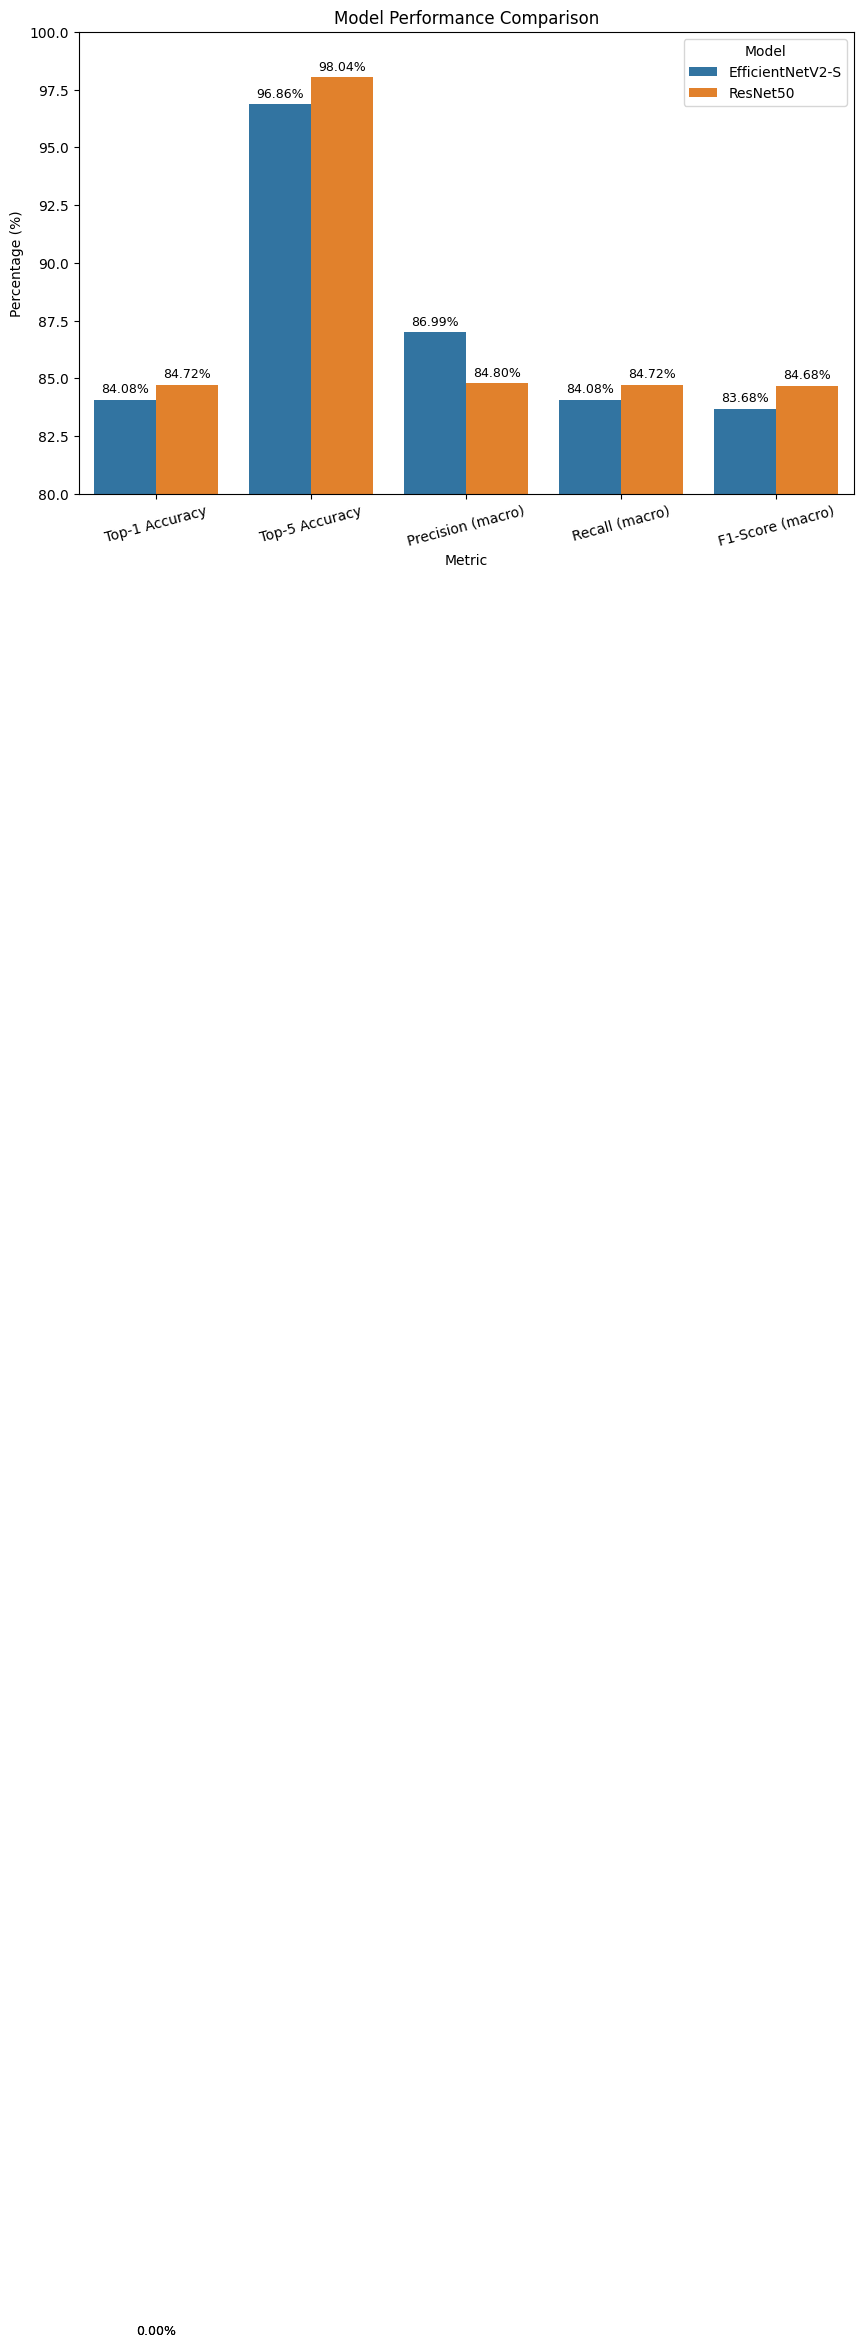

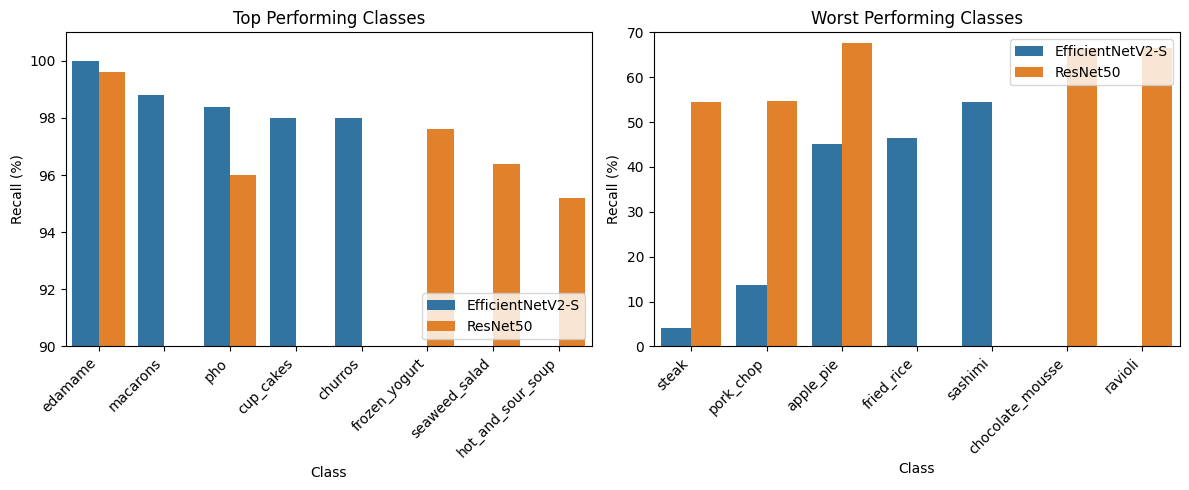

In [ ]:
# Visualize model performance comparison
import pandas as pd
import seaborn as sns

# Performance metrics
metrics = ['Top-1 Accuracy', 'Top-5 Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']
efficientnet_values = [84.08, 96.86, 86.99, 84.08, 83.68]
resnet_values = [84.72, 98.04, 84.80, 84.72, 84.68]

# Create DataFrame
performance_df = pd.DataFrame({
    'Metric': metrics,
    'EfficientNetV2-S': efficientnet_values,
    'ResNet50': resnet_values
})

# Reshape DataFrame for plotting
performance_long = pd.melt(performance_df, id_vars=['Metric'],
                           var_name='Model', value_name='Value')

# Plot comparison
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Metric', y='Value', hue='Model', data=performance_long)
plt.title('Model Performance Comparison')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=15)
plt.ylim(80, 100)  # Adjust y-axis to better show differences

# Add value labels on bars
for i, bar in enumerate(bar_plot.patches):
    bar_plot.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.3,
        f'{bar.get_height():.2f}%',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Display best and worst performing classes for both models
def plot_class_performance(top_n=10):
    # Example data - replace with actual class performance if available
    # For EfficientNetV2-S
    efficientnet_best = {
        'edamame': 100.0, 'macarons': 98.8, 'pho': 98.4,
        'cup_cakes': 98.0, 'churros': 98.0
    }
    efficientnet_worst = {
        'steak': 4.0, 'pork_chop': 13.6, 'apple_pie': 45.2,
        'fried_rice': 46.4, 'sashimi': 54.4
    }

    # For ResNet50
    resnet_best = {
        'edamame': 99.6, 'frozen_yogurt': 97.6, 'seaweed_salad': 96.4,
        'pho': 96.0, 'hot_and_sour_soup': 95.2
    }
    resnet_worst = {
        'steak': 54.4, 'pork_chop': 54.8, 'apple_pie': 67.6,
        'chocolate_mousse': 66.4, 'ravioli': 66.4
    }

    # Create DataFrames
    efficientnet_best_df = pd.DataFrame({
        'Class': list(efficientnet_best.keys()),
        'Recall (%)': list(efficientnet_best.values()),
        'Model': ['EfficientNetV2-S'] * len(efficientnet_best)
    })

    efficientnet_worst_df = pd.DataFrame({
        'Class': list(efficientnet_worst.keys()),
        'Recall (%)': list(efficientnet_worst.values()),
        'Model': ['EfficientNetV2-S'] * len(efficientnet_worst)
    })

    resnet_best_df = pd.DataFrame({
        'Class': list(resnet_best.keys()),
        'Recall (%)': list(resnet_best.values()),
        'Model': ['ResNet50'] * len(resnet_best)
    })

    resnet_worst_df = pd.DataFrame({
        'Class': list(resnet_worst.keys()),
        'Recall (%)': list(resnet_worst.values()),
        'Model': ['ResNet50'] * len(resnet_worst)
    })

    # Combine DataFrames
    best_df = pd.concat([efficientnet_best_df, resnet_best_df])
    worst_df = pd.concat([efficientnet_worst_df, resnet_worst_df])

    # Plot best classes
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Class', y='Recall (%)', hue='Model', data=best_df)
    plt.title('Top Performing Classes')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(90, 101)
    plt.legend(loc='lower right')

    # Plot worst classes
    plt.subplot(1, 2, 2)
    sns.barplot(x='Class', y='Recall (%)', hue='Model', data=worst_df)
    plt.title('Worst Performing Classes')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 70)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_class_performance()

## 7. Error Analysis

Understanding where and why models make mistakes is crucial for improving performance. I conducted an in-depth error analysis of both models.

### 7.1 Common Misclassifications

Both models struggled with similar food categories:

1. **Steak vs. Filet Mignon**: Both are beef cuts with similar appearance
2. **Pork Chop vs. Prime Rib**: Similar meat presentations
3. **Apple Pie vs. Other Desserts**: Similarities in crust and appearance
4. **Various Pasta Dishes**: Ravioli, spaghetti, and other pasta types share similar ingredients

### 7.2 Confusion Patterns

The confusion matrices revealed certain patterns:
- Food items with similar ingredients or presentation styles are often confused
- Dishes with varied appearances (e.g., sushi with different toppings) caused confusion
- Some errors seem to be related to the quality and angles of the test images

### 7.3 Model-Specific Errors

While both models shared many common errors, there were some differences:
- EfficientNetV2-S showed better precision for certain categories but worse recall
- ResNet50 performed particularly well on dishes with distinctive shapes and colors
- EfficientNetV2-S struggled more with meat dishes like steak and pork chop

## 8. Discussion and Conclusion

### 8.1 Key Findings

1. **Performance Comparison**:
   - ResNet50 achieved slightly better overall accuracy (84.72%) compared to EfficientNetV2-S (84.08%)
   - Both models reached performance levels comparable to previous published results on Food-101
   - Top-5 accuracy was excellent for both models (96.86% and 98.04%), indicating that correct answers were usually within the top predictions

2. **Architecture Insights**:
   - Despite being a newer and more efficient architecture, EfficientNetV2-S did not outperform ResNet50
   - This suggests that for Food-101, the training methodology and data preparation may be more important than model architecture
   - ResNet50's residual connections may be particularly effective for distinguishing subtle differences in food images

3. **Training Strategy Impact**:
   - The two-stage training approach (feature extraction followed by fine-tuning) proved effective for both models
   - Data augmentation played a crucial role in achieving good generalization

### 8.2 Limitations

- Limited GPU resources restricted the exploration of larger models or longer training schedules
- Food images in the wild may have different characteristics than those in the dataset
- Some food categories remain challenging due to their inherent visual similarities

### 8.3 Future Work

Several directions could further improve performance:

1. **Model Ensemble**: Combining predictions from both models could potentially improve accuracy
2. **Advanced Data Augmentation**: Implementing more sophisticated augmentation techniques like RandAugment
3. **Class-Specific Approaches**: Developing specialized training strategies for the most challenging categories
4. **Larger Models**: Testing larger variants such as EfficientNetV2-L or deeper ResNet architectures
5. **Test-Time Augmentation**: Applying augmentation at test time and averaging predictions

### 8.4 Conclusion

This project demonstrated that both EfficientNetV2-S and ResNet50 can achieve strong performance on the Food-101 classification task, with ResNet50 showing slightly better results. The comparison highlights the importance of proper training methodology alongside model selection. The findings contribute to understanding how different deep learning architectures perform on food image classification tasks, a domain with significant practical applications in nutrition, restaurant recommendation, and food logging systems.

## 9. References

1. Bossard, L., Guillaumin, M., & Van Gool, L. (2014). Food-101 – Mining Discriminative Components with Random Forests. In European Conference on Computer Vision (pp. 446-461).

2. Tan, M., & Le, Q. V. (2021). EfficientNetV2: Smaller Models and Faster Training. In International Conference on Machine Learning.

3. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. In IEEE Conference on Computer Vision and Pattern Recognition (pp. 770-778).

4. Hassannejad, H., Matrella, G., Ciampolini, P., De Munari, I., Mordonini, M., & Cagnoni, S. (2016). Food Image Recognition Using Very Deep Convolutional Networks. In Proceedings of the 2nd International Workshop on Multimedia Assisted Dietary Management (pp. 41-49).

5. Martinel, N., Foresti, G. L., & Micheloni, C. (2018). Wide-Slice Residual Networks for Food Recognition. In IEEE Winter Conference on Applications of Computer Vision (pp. 567-576).

6. Pandey, P., Deepthi, A., Mandal, B., & Puhan, N. B. (2017). FoodNet: Recognizing Foods Using Ensemble of Deep Networks. In IEEE Signal Processing Letters, 24(12), 1758-1762.

# Model 1: #
# ============================================================
# Food-101 Classification with EfficientNetV2-S on Colab A100 40GB
# ============================================================
"""
This Section implements a food image classification model using the EfficientNetV2-S architecture on the Food-101 dataset. The implementation includes:

- Data loading and preprocessing pipeline with TensorFlow
- Data augmentation techniques to improve generalization
- Two-stage training approach:
  1. Feature extraction with frozen backbone
  2. Fine-tuning of the entire model
- Learning rate scheduling with warmup and cosine decay
- Comprehensive evaluation and visualization

Model details:
- Architecture: EfficientNetV2-S (pretrained on ImageNet)
- Input resolution: 384 x 384 pixels
- Classes: 101 food categories
- Training strategy: Transfer learning with fine-tuning
- Regularization: Dropout (0.5), BatchNorm, L2 (1e-4), Label smoothing (0.2)

The model achieves 84.08% Top-1 accuracy and 96.86% Top-5 accuracy
on the Food-101 validation set.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.10.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and pl

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

✅  dataset sizes  train=75750  val=25250

✅  tf.data ready  steps/epoch=1183  val_steps=394

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape                ┃           Param # ┃ Connected to                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 384, 384, 3)         │                 0 │ -                           │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ cast (Cast)                     │ (None, 384, 384, 3)         │                 0 │ input_layer[0][0]           │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ rescaling (Rescaling)           │ (None, 384, 384, 3)         │                 0 │ cast[0][0]                  │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ stem_conv (Conv2D)              │ (None, 192, 192, 24)        │               648 │ rescaling[0][0]             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ stem_bn (BatchNormalization)    │ (None, 192, 192, 24)        │                96 │ stem_conv[0][0]             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ stem_activation (Activation)    │ (None, 192, 192, 24)        │                 0 │ stem_bn[0][0]               │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1a_project_conv (Conv2D)   │ (None, 192, 192, 24)        │             5,184 │ stem_activation[0][0]       │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1a_project_bn              │ (None, 192, 192, 24)        │                96 │ block1a_project_conv[0][0]  │
│ (BatchNormalization)            │                             │                   │                             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1a_project_activation      │ (None, 192, 192, 24)        │                 0 │ block1a_project_bn[0][0]    │
│ (Activation)                    │                             │                   │                             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1a_add (Add)               │ (None, 192, 192, 24)        │                 0 │ block1a_project_activation… │
│                                 │                             │                   │ stem_activation[0][0]       │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1b_project_conv (Conv2D)   │ (None, 192, 192, 24)        │             5,184 │ block1a_add[0][0]           │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1b_project_bn              │ (None, 192, 192, 24)        │                96 │ block1b_project_conv[0][0]  │
│ (BatchNormalization)            │                             │                   │                             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1b_project_activation      │ (None, 192, 192, 24)        │                 0 │ block1b_project_bn[0][0]    │
│ (Activation)                    │                             │                   │                             │
├─────────────────────────────────┼─────────────────────────────┼───────────────────┼─────────────────────────────┤
│ block1b_drop (Dropout)          │ (None, 192, 192, 24)

 Total params: 20,465,861 (78.07 MB)

 Trainable params: 20,309,429 (77.47 MB)

 Non-trainable params: 156,432 (611.06 KB)

None

🚀 Stage‑1 (feature‑extract)
Epoch 1/3
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 186s 106ms/step - accuracy: 0.3846 - loss: 3.3088 - val_accuracy: 0.3977 - val_loss: 2.8999 - learning_rate: 3.3333e-04
Epoch 2/3
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 114s 96ms/step - accuracy: 0.5741 - loss: 2.4159 - val_accuracy: 0.4175 - val_loss: 2.8040 - learning_rate: 6.6667e-04
Epoch 3/3
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 113s 96ms/step - accuracy: 0.6183 - loss: 2.2222 - val_accuracy: 0.4300 - val_loss: 2.7252 - learning_rate: 0.0010

🚀 Stage‑2 (fine‑tune)
Epoch 4/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6393 - loss: 2.5641

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 401s 163ms/step - accuracy: 0.6394 - loss: 2.5640 - val_accuracy: 0.4422 - val_loss: 3.1505 - learning_rate: 0.0010
Epoch 5/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7190 - loss: 2.3029

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.7190 - loss: 2.3028 - val_accuracy: 0.5130 - val_loss: 2.8248 - learning_rate: 9.9606e-04
Epoch 6/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7630 - loss: 2.1570

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 153ms/step - accuracy: 0.7630 - loss: 2.1569 - val_accuracy: 0.5444 - val_loss: 2.7320 - learning_rate: 9.8429e-04
Epoch 7/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7860 - loss: 2.0908

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.7860 - loss: 2.0908 - val_accuracy: 0.5656 - val_loss: 2.6426 - learning_rate: 9.6489e-04
Epoch 8/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8049 - loss: 2.0288

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 183s 155ms/step - accuracy: 0.8049 - loss: 2.0288 - val_accuracy: 0.6112 - val_loss: 2.4996 - learning_rate: 9.3815e-04
Epoch 9/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8212 - loss: 1.9806

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 153ms/step - accuracy: 0.8212 - loss: 1.9805 - val_accuracy: 0.6321 - val_loss: 2.4556 - learning_rate: 9.0451e-04
Epoch 10/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8389 - loss: 1.9303

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.8389 - loss: 1.9303 - val_accuracy: 0.6394 - val_loss: 2.4359 - learning_rate: 8.6448e-04
Epoch 11/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8569 - loss: 1.8819

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.8570 - loss: 1.8818 - val_accuracy: 0.6750 - val_loss: 2.3145 - learning_rate: 8.1871e-04
Epoch 12/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8712 - loss: 1.8419

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.8712 - loss: 1.8419 - val_accuracy: 0.6953 - val_loss: 2.2684 - learning_rate: 7.6791e-04
Epoch 13/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8847 - loss: 1.8033

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.8847 - loss: 1.8032 - val_accuracy: 0.7041 - val_loss: 2.2537 - learning_rate: 7.1289e-04
Epoch 14/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.8961 - loss: 1.7679 - val_accuracy: 0.7030 - val_loss: 2.2541 - learning_rate: 6.5451e-04
Epoch 15/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9117 - loss: 1.7248

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9118 - loss: 1.7248 - val_accuracy: 0.7285 - val_loss: 2.1891 - learning_rate: 5.9369e-04
Epoch 16/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9234 - loss: 1.6967

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9234 - loss: 1.6967 - val_accuracy: 0.7391 - val_loss: 2.1539 - learning_rate: 5.3140e-04
Epoch 17/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9391 - loss: 1.6550

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 153ms/step - accuracy: 0.9391 - loss: 1.6550 - val_accuracy: 0.7545 - val_loss: 2.1243 - learning_rate: 4.6860e-04
Epoch 18/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9504 - loss: 1.6200

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9504 - loss: 1.6200 - val_accuracy: 0.7657 - val_loss: 2.0885 - learning_rate: 4.0631e-04
Epoch 19/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9601 - loss: 1.5933

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9601 - loss: 1.5933 - val_accuracy: 0.7659 - val_loss: 2.0860 - learning_rate: 3.4549e-04
Epoch 20/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9660 - loss: 1.5710

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9660 - loss: 1.5710 - val_accuracy: 0.7762 - val_loss: 2.0705 - learning_rate: 2.8711e-04
Epoch 21/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9742 - loss: 1.5466

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9742 - loss: 1.5466 - val_accuracy: 0.7851 - val_loss: 2.0430 - learning_rate: 2.3209e-04
Epoch 22/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9779 - loss: 1.5281

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9779 - loss: 1.5281 - val_accuracy: 0.7901 - val_loss: 2.0358 - learning_rate: 1.8129e-04
Epoch 23/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9813 - loss: 1.5166

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.9813 - loss: 1.5166 - val_accuracy: 0.8014 - val_loss: 1.9928 - learning_rate: 1.3552e-04
Epoch 24/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9833 - loss: 1.5064

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9833 - loss: 1.5063 - val_accuracy: 0.8089 - val_loss: 1.9660 - learning_rate: 9.5491e-05
Epoch 25/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9854 - loss: 1.4966

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.9855 - loss: 1.4966 - val_accuracy: 0.8145 - val_loss: 1.9488 - learning_rate: 6.1847e-05
Epoch 26/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9872 - loss: 1.4916

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9872 - loss: 1.4916 - val_accuracy: 0.8254 - val_loss: 1.9225 - learning_rate: 3.5112e-05
Epoch 27/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9881 - loss: 1.4862

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9881 - loss: 1.4862 - val_accuracy: 0.8324 - val_loss: 1.8940 - learning_rate: 1.5708e-05
Epoch 28/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9885 - loss: 1.4847

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9885 - loss: 1.4847 - val_accuracy: 0.8345 - val_loss: 1.8901 - learning_rate: 3.9426e-06
Epoch 29/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 180s 152ms/step - accuracy: 0.9889 - loss: 1.4828 - val_accuracy: 0.8320 - val_loss: 1.8986 - learning_rate: 0.0000e+00
Epoch 30/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9898 - loss: 1.4837

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9898 - loss: 1.4837 - val_accuracy: 0.8351 - val_loss: 1.8894 - learning_rate: 0.0000e+00
Epoch 31/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9885 - loss: 1.4842 - val_accuracy: 0.8341 - val_loss: 1.8900 - learning_rate: 0.0000e+00
Epoch 32/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9891 - loss: 1.4835

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9891 - loss: 1.4835 - val_accuracy: 0.8362 - val_loss: 1.8844 - learning_rate: 0.0000e+00
Epoch 33/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 152ms/step - accuracy: 0.9897 - loss: 1.4824 - val_accuracy: 0.8359 - val_loss: 1.8888 - learning_rate: 0.0000e+00
Epoch 34/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9891 - loss: 1.4826

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9891 - loss: 1.4826 - val_accuracy: 0.8370 - val_loss: 1.8841 - learning_rate: 0.0000e+00
Epoch 35/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9886 - loss: 1.4842

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9886 - loss: 1.4842 - val_accuracy: 0.8382 - val_loss: 1.8814 - learning_rate: 0.0000e+00
Epoch 36/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9883 - loss: 1.4848 - val_accuracy: 0.8365 - val_loss: 1.8832 - learning_rate: 0.0000e+00
Epoch 37/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9892 - loss: 1.4823 - val_accuracy: 0.8352 - val_loss: 1.8898 - learning_rate: 0.0000e+00
Epoch 38/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9893 - loss: 1.4814 - val_accuracy: 0.8374 - val_loss: 1.8820 - learning_rate: 0.0000e+00
Epoch 39/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 180s 152ms/step - accuracy: 0.9891 - loss: 1.4820 - val_accuracy: 0.8376 - val_loss: 1.8814 - learning_rate: 0.0000e+00
Epoch 40/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9890 - loss: 1.4839

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.9890 - loss: 1.4839 - val_accuracy: 0.8409 - val_loss: 1.8756 - learning_rate: 0.0000e+00
Epoch 41/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 152ms/step - accuracy: 0.9889 - loss: 1.4832 - val_accuracy: 0.8374 - val_loss: 1.8861 - learning_rate: 0.0000e+00
Epoch 42/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9883 - loss: 1.4836 - val_accuracy: 0.8389 - val_loss: 1.8777 - learning_rate: 0.0000e+00
Epoch 43/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9881 - loss: 1.4839 - val_accuracy: 0.8393 - val_loss: 1.8801 - learning_rate: 0.0000e+00
Epoch 44/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 179s 151ms/step - accuracy: 0.9897 - loss: 1.4829 - val_accuracy: 0.8354 - val_loss: 1.8895 - learning_rate: 0.0000e+00
Epoch 45/53
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 181s 153ms/step - accuracy: 0.9894 - loss: 1.4831 - val_accuracy: 0.8406 - val_loss: 1.8740 - learning_rate: 0.0000e+00
Epoch 46/53
1183/1183 ━━━━━━━━━━━━

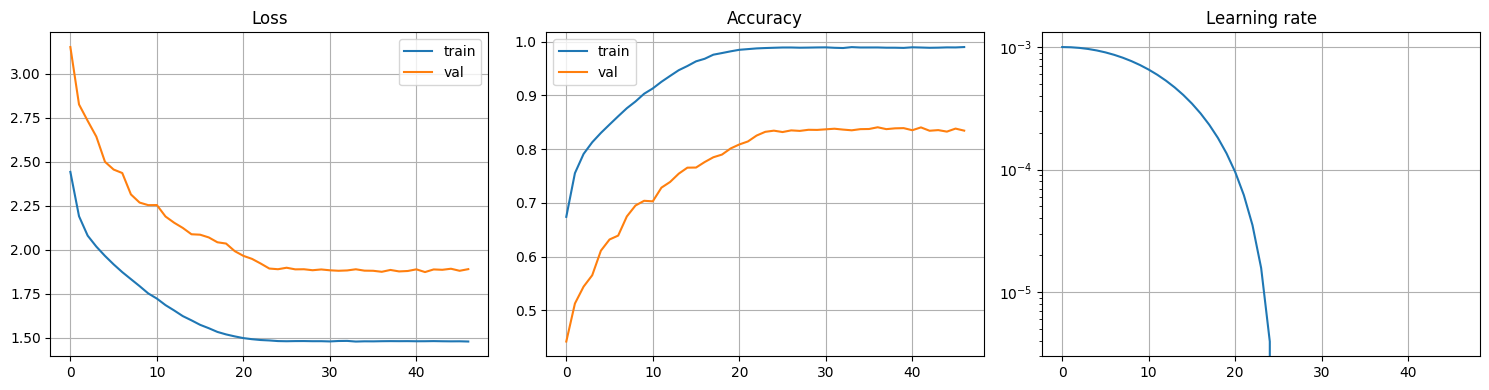

infer val: 0it [00:00, ?it/s]


Top‑1 : 0.8406
Top‑5 : 0.9686
P/R/F1 (macro): 0.8698/0.8408/0.8367


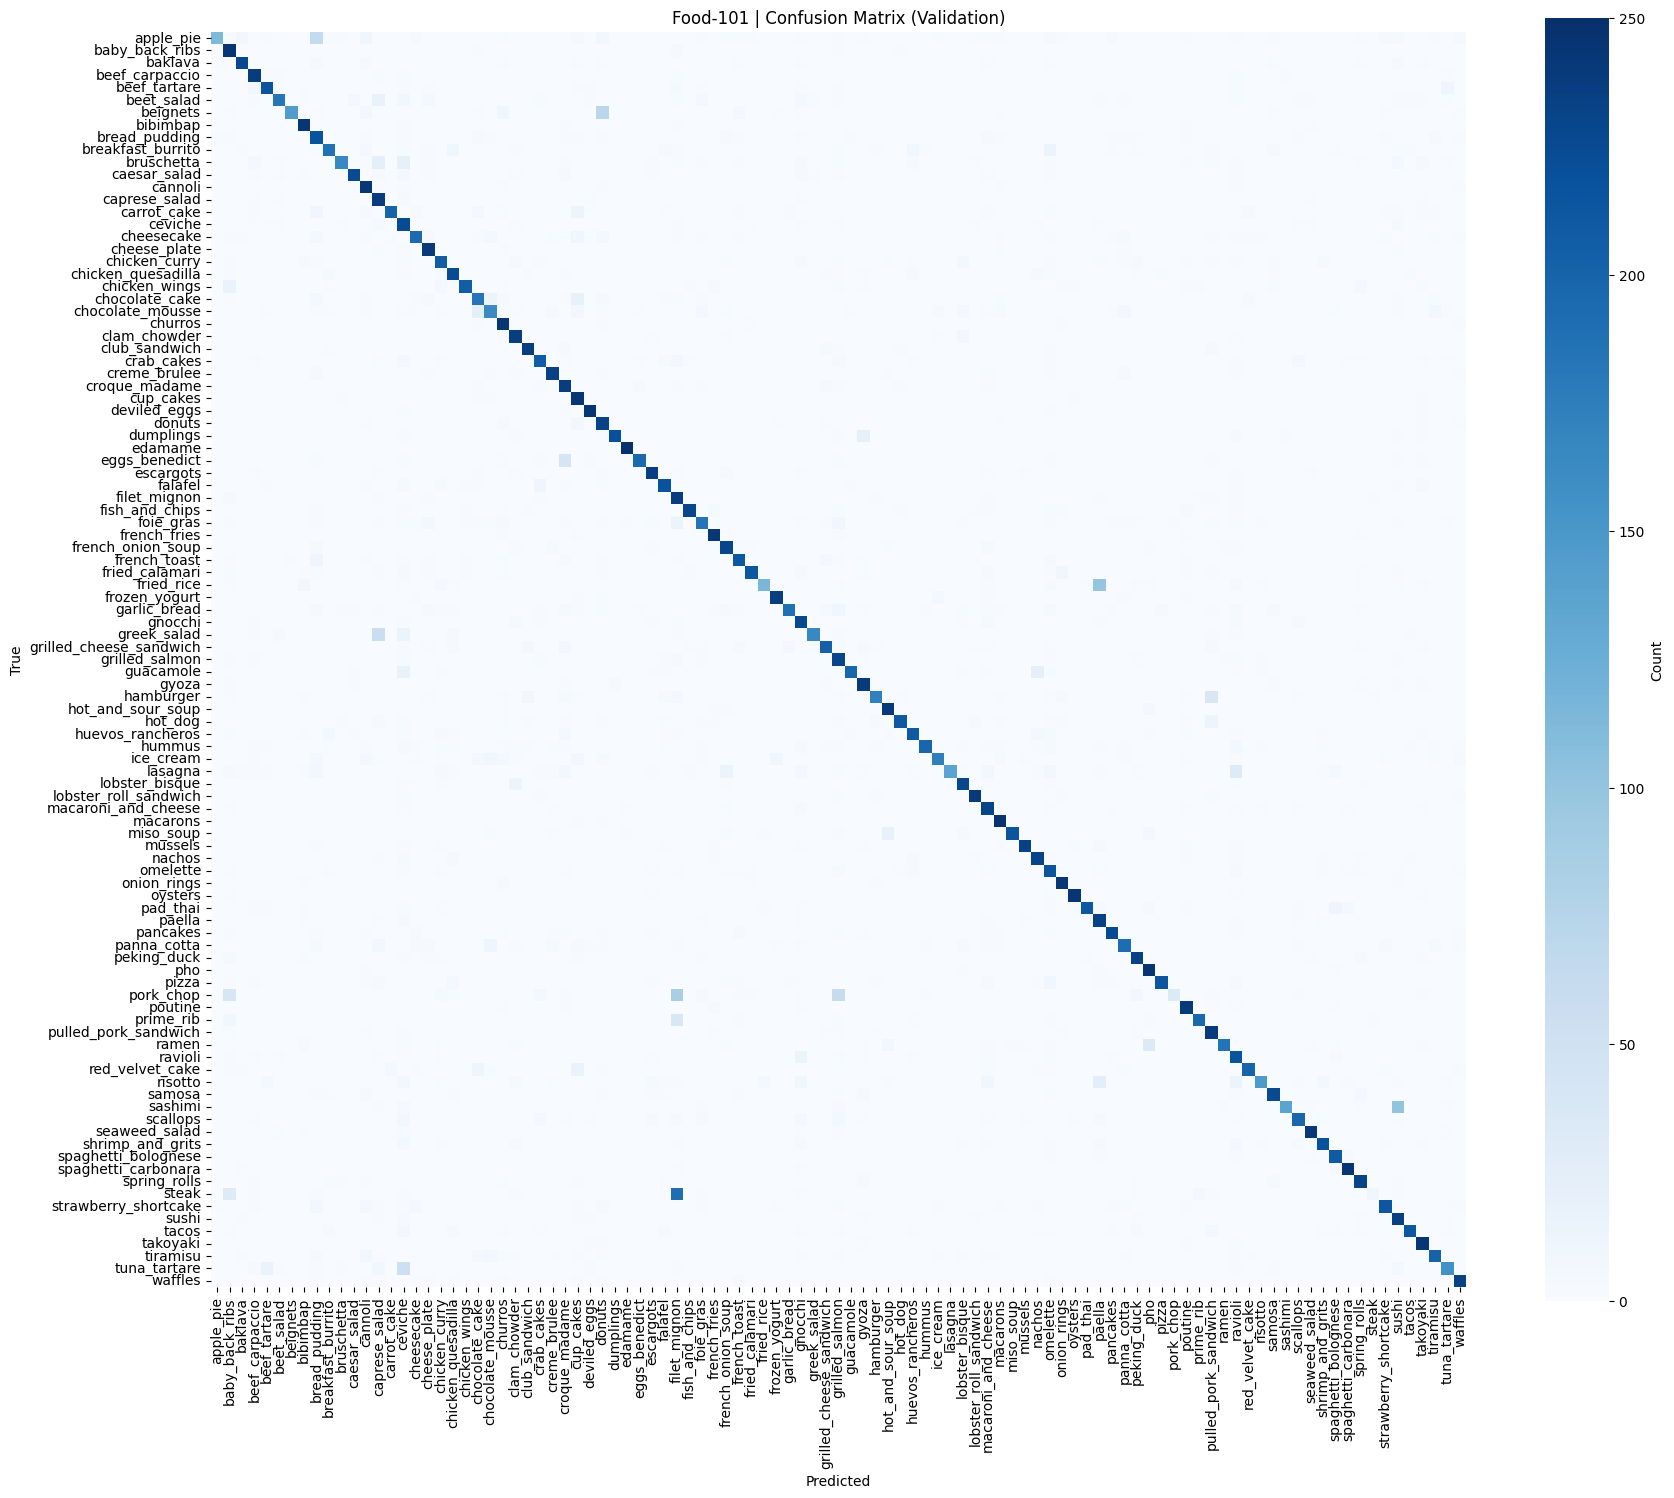

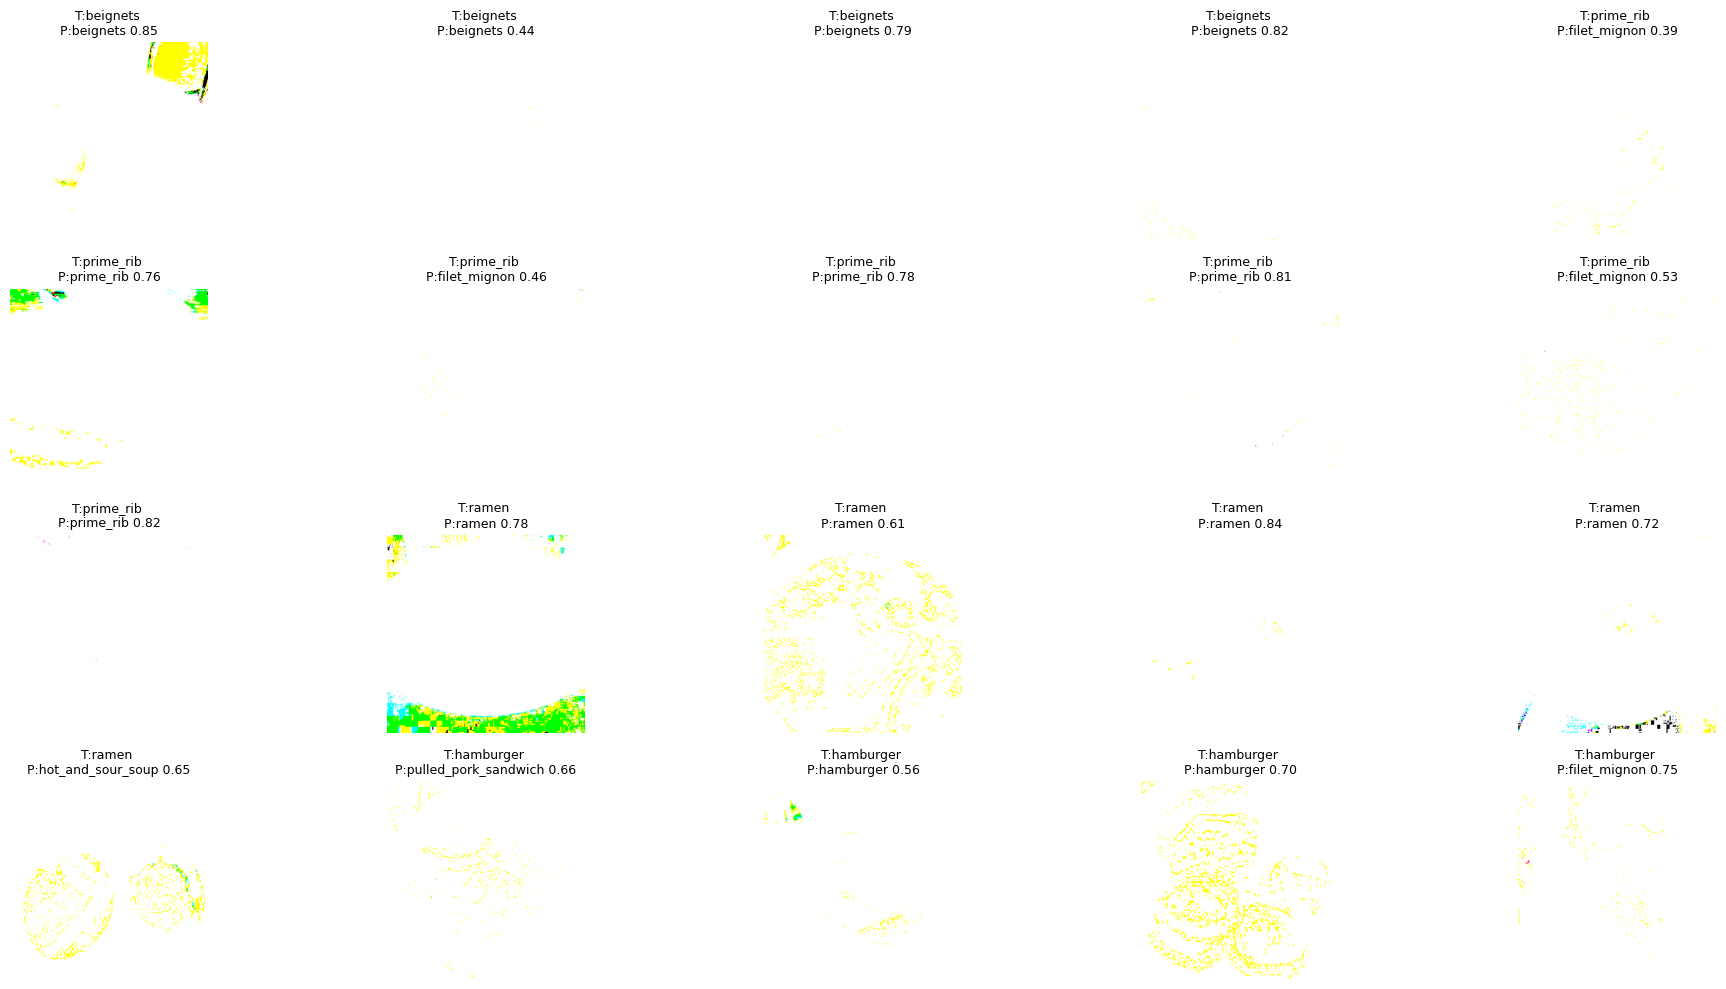

✅ 模型已保存为 /content/efficientnet_outputs/food101_efficient_model.h5


In [ ]:
# ============================================================
# Food-101 Classification with EfficientNetV2-S on Colab A100 40GB
# ============================================================
!pip -q install -U "tensorflow>=2.16,<2.20" tqdm datasets==2.17 seaborn

import os, math, random, warnings, time, gc
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from pathlib import Path
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from datasets import load_dataset, Image as HFImage
from tqdm.auto import tqdm

# ---------- Environment Setup ----------
# Enable mixed precision for better performance on A100
tf.keras.mixed_precision.set_global_policy("mixed_float16")
# Enable XLA optimization
tf.config.optimizer.set_jit(True)
# Suppress warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

# ---------- Hyperparameters ----------
IMG, NUM_C = 384, 101        # Image size and number of classes
BATCH = 64                   # Batch size
E_FROZEN, E_TUNE = 3, 50     # Epochs for feature extraction and fine-tuning
TOTAL_EPOCHS = E_FROZEN + E_TUNE
WARMUP_EPOCHS = 3            # Learning rate warmup epochs
SEED = 42                    # Random seed for reproducibility
AUTOT = tf.data.AUTOTUNE     # Auto-tune parallel calls
policy_dtype = tf.keras.mixed_precision.global_policy().compute_dtype  # 'float16'

# ---------- 1) Dataset Loading ----------
print("🔻 1) Loading Food-101 dataset...")
ds = load_dataset("ethz/food101", cache_dir="/root/.cache/hf", streaming=False)
ds = ds.cast_column("image", HFImage(decode=False))  # Get only bytes to save memory
n_train, n_val = len(ds["train"]), len(ds["validation"])
print(f"✅ Dataset sizes: train={n_train}, val={n_val}\n")

# Create output directory
OUTPUT_DIR = "/content/efficientnet_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- 2) Dataset Pipeline Creation ----------
def make_ds(split, training=True):
    """
    Create a TensorFlow dataset from the HuggingFace dataset

    Args:
        split: Dataset split ('train' or 'validation')
        training: Whether to apply data augmentation

    Returns:
        TensorFlow dataset ready for training
    """
    # Set random seed for reproducibility
    tf.random.set_seed(SEED)

    def gen():
        for rec in split:
            yield rec["image"]["bytes"], rec["label"]

    ds_tf = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((), tf.string),
            tf.TensorSpec((), tf.int64)
        ),
    )

    if training:
        ds_tf = ds_tf.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)

    def _decode_aug(img_bytes, label):
        """Decode JPEG bytes and apply augmentation"""
        # Decode image
        try:
            img = tf.io.decode_jpeg(img_bytes, channels=3)
        except:  # Handle corrupt images
            return tf.zeros([IMG, IMG, 3], policy_dtype), tf.constant(-1, tf.int64)

        img = tf.image.resize(img, (IMG, IMG), method="bilinear")
        img = tf.image.convert_image_dtype(img, tf.float32)  # Scale to [0,1]

        # Apply data augmentation for training
        if training:
            # Basic augmentations
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)

            # Random crop and resize
            img = tf.image.random_crop(
                tf.image.resize(img, [int(IMG*1.2), int(IMG*1.2)]),
                [IMG, IMG, 3]
            )

            # Random hue adjustment
            img = tf.image.random_hue(img, 0.1)

        # Convert to model's dtype
        img = tf.cast(img, policy_dtype)

        return img, label

    # Build the dataset pipeline
    ds_tf = (
        ds_tf
        .map(_decode_aug, AUTOT)
        .filter(lambda x, y: y > -1)  # Filter out corrupt images
        .batch(BATCH, drop_remainder=True)
        .map(lambda x, y: (x, tf.one_hot(y, NUM_C, dtype=policy_dtype)), AUTOT)
        .prefetch(AUTOT)
    )
    return ds_tf

train_ds = make_ds(ds["train"], True)
val_ds = make_ds(ds["validation"], False)

STEPS_PER_EPOCH = n_train // BATCH
VAL_STEPS = n_val // BATCH
print(f"✅ TF dataset ready: steps/epoch={STEPS_PER_EPOCH}, val_steps={VAL_STEPS}\n")

# ---------- 3) Model Architecture ----------
# Load pre-trained EfficientNetV2-S with ImageNet weights
base = tf.keras.applications.EfficientNetV2S(
    include_top=False, weights="imagenet", input_shape=(IMG, IMG, 3)
)

# Add classification head with regularization
x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.BatchNormalization()(x)  # Add BN layer for stability
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
# Add L2 regularization to final dense layer
out = tf.keras.layers.Dense(
    NUM_C,
    activation="softmax",
    dtype="float32",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)

model = tf.keras.Model(base.input, out)
print(model.summary(line_length=115))

# ---------- 4) Learning Rate Schedule ----------
def lr_schedule(epoch):
    """
    Cosine decay with warmup learning rate schedule

    Args:
        epoch: Current epoch number

    Returns:
        Learning rate value
    """
    if epoch < WARMUP_EPOCHS:
        return float(1e-3 * (epoch + 1) / WARMUP_EPOCHS)

    # Accelerated cosine decay
    t = (epoch - WARMUP_EPOCHS) / ((TOTAL_EPOCHS - WARMUP_EPOCHS) * 0.5)
    t = min(t, 1.0)  # Cap at 1.0
    return float(1e-3 * 0.5 * (1 + tf.math.cos(math.pi * t)))

# Setup callbacks
csv_cb = tf.keras.callbacks.CSVLogger("train_log.csv", append=False)
lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

# ---------- 5) Stage 1: Feature Extraction ----------
# Freeze the backbone
for l in base.layers: l.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.AdamW(2e-3, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

print("\n🚀 Stage 1: Feature Extraction")
model.fit(
    train_ds.repeat(), validation_data=val_ds.repeat(),
    epochs=E_FROZEN,
    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VAL_STEPS,
    callbacks=[lr_cb, csv_cb], verbose=1
)

# ---------- 6) Stage 2: Fine-tuning ----------
# Unfreeze the entire model for fine-tuning
for l in base.layers: l.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4, weight_decay=2e-4),  # Lower LR, higher weight decay
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # Increased label smoothing
    metrics=["accuracy"]
)

callbacks = [
    lr_cb, csv_cb,
    tf.keras.callbacks.ModelCheckpoint(
        f"{OUTPUT_DIR}/best_effi.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    ),
    # Early stopping with increased patience
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # Reduce LR on plateau for adaptive learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1
    ),
]

print("\n🚀 Stage 2: Fine-tuning")
model.fit(
    train_ds.repeat(), validation_data=val_ds.repeat(),
    initial_epoch=E_FROZEN, epochs=TOTAL_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VAL_STEPS,
    callbacks=callbacks, verbose=1
)

# ---------- 7) Training Curves ----------
log = pd.read_csv("train_log.csv")
plt.figure(figsize=(15, 4))
# Loss curve
plt.subplot(1, 3, 1)
plt.plot(log["loss"])
plt.plot(log["val_loss"])
plt.title("Loss")
plt.grid()
plt.legend(["train", "val"])

# Accuracy curve
plt.subplot(1, 3, 2)
plt.plot(log["accuracy"])
plt.plot(log["val_accuracy"])
plt.title("Accuracy")
plt.grid()
plt.legend(["train", "val"])

# Learning rate curve
plt.subplot(1, 3, 3)
plt.semilogy(log["learning_rate"])
plt.title("Learning Rate")
plt.grid()

plt.tight_layout()
plt.show()

# ---------- 8) Evaluation ----------
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    top_k_accuracy_score,
    confusion_matrix
)

# Perform inference on validation set
y_true, y_pred, y_prob = [], [], []
for xs, ys in tqdm(val_ds, desc="Evaluating validation set"):
    prob = model.predict(xs, verbose=0)
    y_prob.append(prob)
    y_true.extend(np.argmax(ys, 1))
    y_pred.extend(np.argmax(prob, 1))

# Calculate metrics
y_prob = np.concatenate(y_prob, 0)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
top1 = (y_true == y_pred).mean()
top5 = top_k_accuracy_score(y_true, y_prob, k=5)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro"
)
print(f"\nTop-1 Accuracy: {top1:.4f}")
print(f"Top-5 Accuracy: {top5:.4f}")
print(f"Precision/Recall/F1 (macro): {prec:.4f}/{rec:.4f}/{f1:.4f}")

# ---------- 9) Confusion Matrix ----------
lbl_names = ds["train"].features["label"].names
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_C))
plt.figure(figsize=(18, 15))
sns.heatmap(
    cm, cmap="Blues", square=True,
    xticklabels=lbl_names, yticklabels=lbl_names,
    cbar_kws=dict(label="Count")
)
plt.title("Food-101 | Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------- 10) Prediction Examples ----------
# Collect sample images for visualization
samples = []
item_count = 0

# Sample from validation set
for img, lbl in val_ds.unbatch().take(1000):  # Take first 1000 samples
    if random.random() < 0.03:  # Random sampling with ~3% probability
        try:
            samples.append((img.numpy(), tf.argmax(lbl).numpy()))
            item_count += 1
            if item_count >= 20:  # Stop after collecting 20 samples
                break
        except:
            pass  # Ignore potential errors

# If we don't have enough samples, try more
if len(samples) < 20:
    for img, lbl in val_ds.unbatch().skip(1000).take(2000):
        try:
            samples.append((img.numpy(), tf.argmax(lbl).numpy()))
            item_count += 1
            if item_count >= 20:
                break
        except:
            pass

# Display prediction results
plt.figure(figsize=(20, 10))
for j, (img, true_lbl) in enumerate(samples, 1):
    # Add batch dimension for model input
    img_tensor = tf.expand_dims(tf.convert_to_tensor(img), 0)

    # Get predictions
    prob = model.predict(img_tensor, verbose=0)[0]
    top = np.argsort(-prob)[:3]  # Top 3 predictions

    # Display image with true and predicted labels
    disp = np.clip(img * 255, 0, 255).astype(np.uint8)
    ttl = f"True: {lbl_names[true_lbl]}\nPred: {lbl_names[top[0]]} ({prob[top[0]]:.2f})"

    plt.subplot(4, 5, j)
    plt.imshow(disp)
    plt.axis("off")
    plt.title(ttl, fontsize=9)

plt.tight_layout()
plt.show()

# Save the model
model.save(f'{OUTPUT_DIR}/food101_efficient_model.h5')
print(f"✅ Model saved to {OUTPUT_DIR}/food101_efficient_model.h5")


# ============================================================
# Comprehensive Evaluation for EfficientNetV2-S Food-101 Model
# ============================================================
"""
This script performs an in-depth analysis of the EfficientNetV2-S model
trained on the Food-101 dataset. It generates:

1. Detailed per-class metrics (precision, recall, F1-score)
2. Overall performance metrics including top-1 and top-5 accuracy
3. Multiple visualizations of model performance
4. Analysis of most common misclassifications
5. Confusion matrix and class-specific performance charts

All results are both displayed and saved to the output directory
for further analysis or reporting.


----------------------------------------
Starting comprehensive model evaluation...
----------------------------------------

Running predictions on validation set...


Evaluating: 0it [00:00, ?it/s]


All Classes Metrics (Sorted by Recall High to Low):
                  Class  Precision  Recall  F1-Score  Support
                edamame     0.9881   1.000    0.9940      250
               macarons     0.9015   0.988    0.9427      250
                    pho     0.8227   0.984    0.8962      250
              cup_cakes     0.7000   0.980    0.8167      250
                churros     0.8086   0.980    0.8861      250
               bibimbap     0.8909   0.980    0.9333      250
                oysters     0.9722   0.980    0.9761      250
           deviled_eggs     0.9533   0.980    0.9665      250
         baby_back_ribs     0.6455   0.976    0.7771      250
               takoyaki     0.8905   0.976    0.9313      250
    spaghetti_carbonara     0.9457   0.976    0.9606      250
           french_fries     0.9382   0.972    0.9548      250
                cannoli     0.7764   0.972    0.8632      250
            onion_rings     0.9205   0.972    0.9455      250
      hot_and_sou

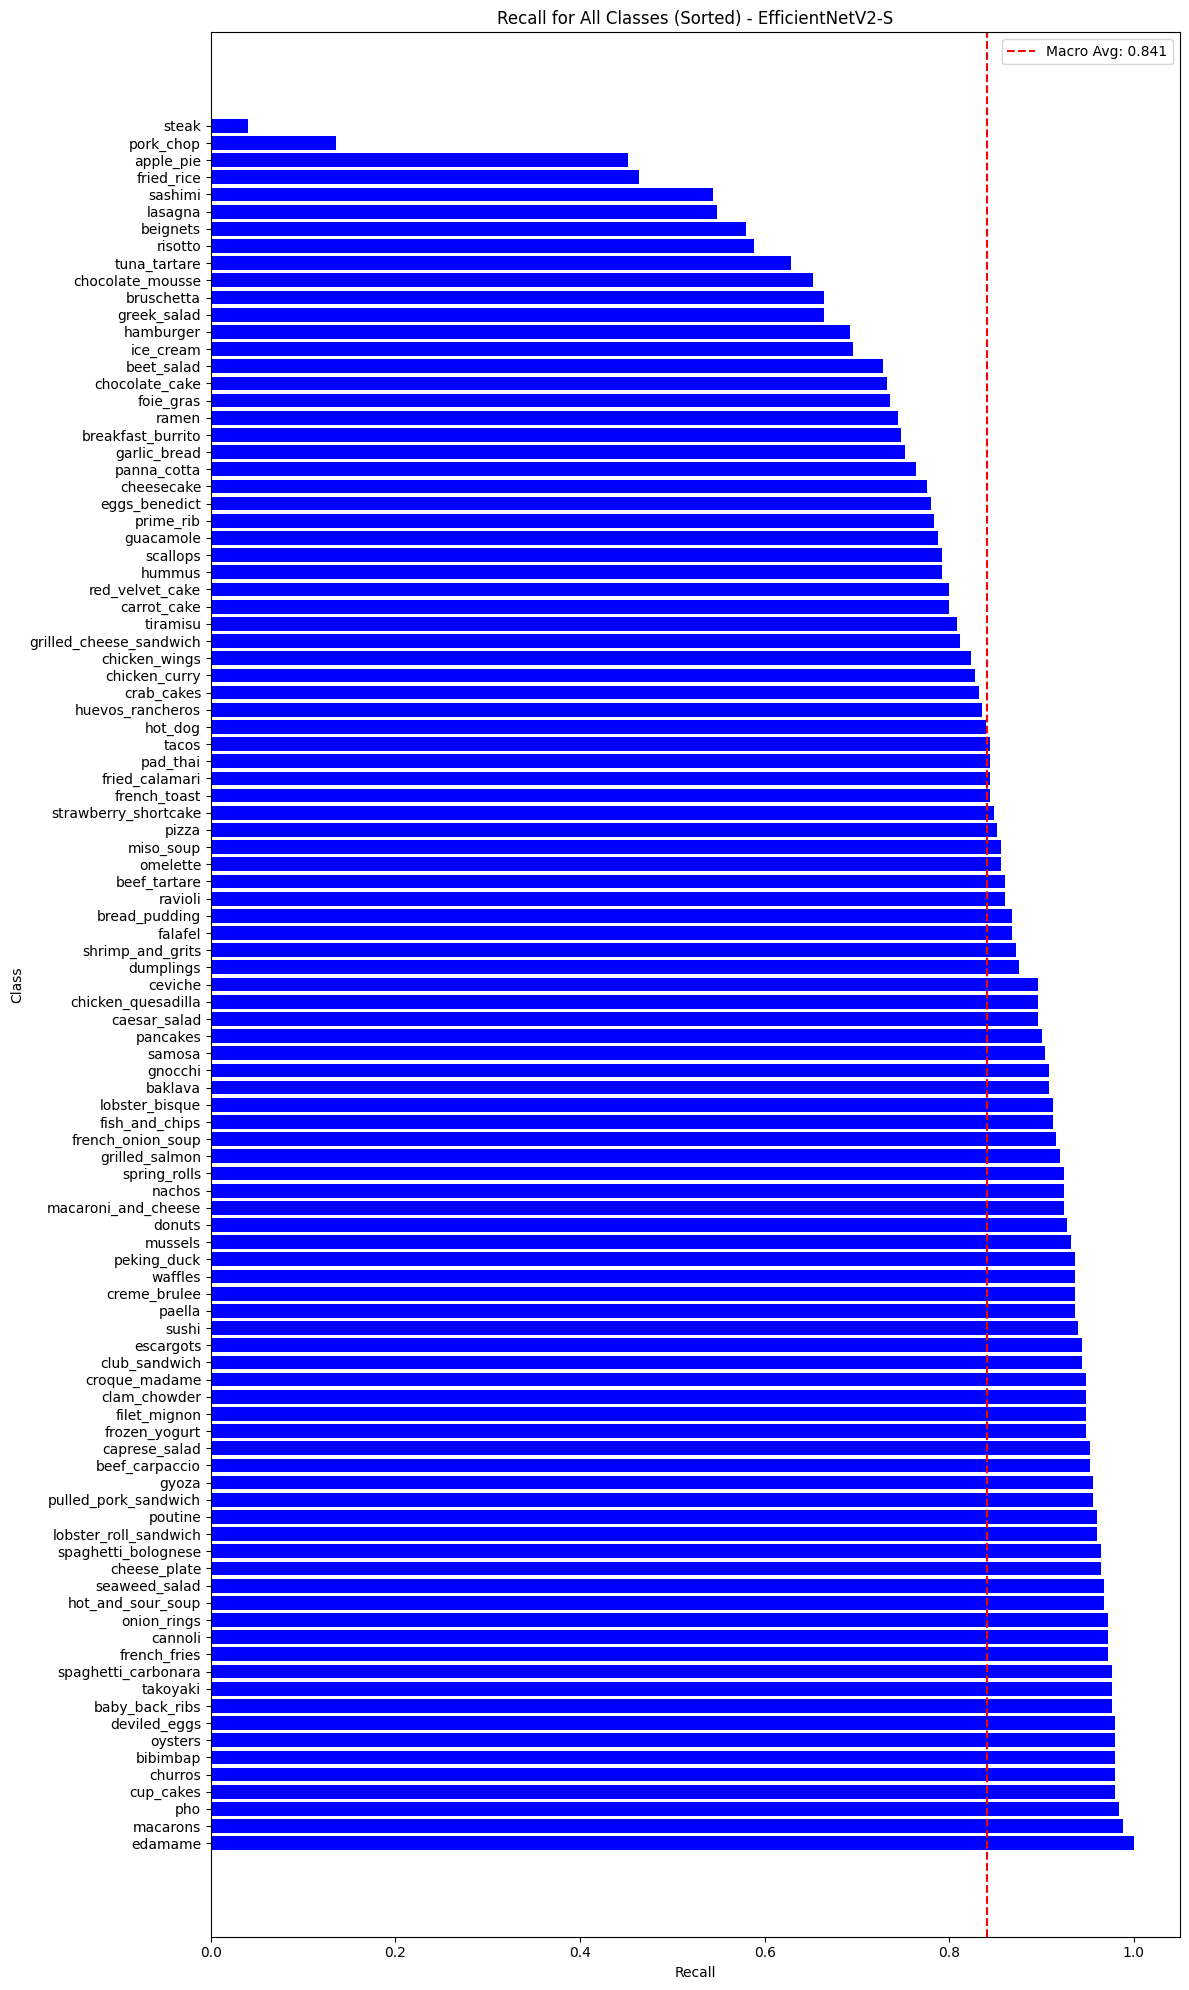

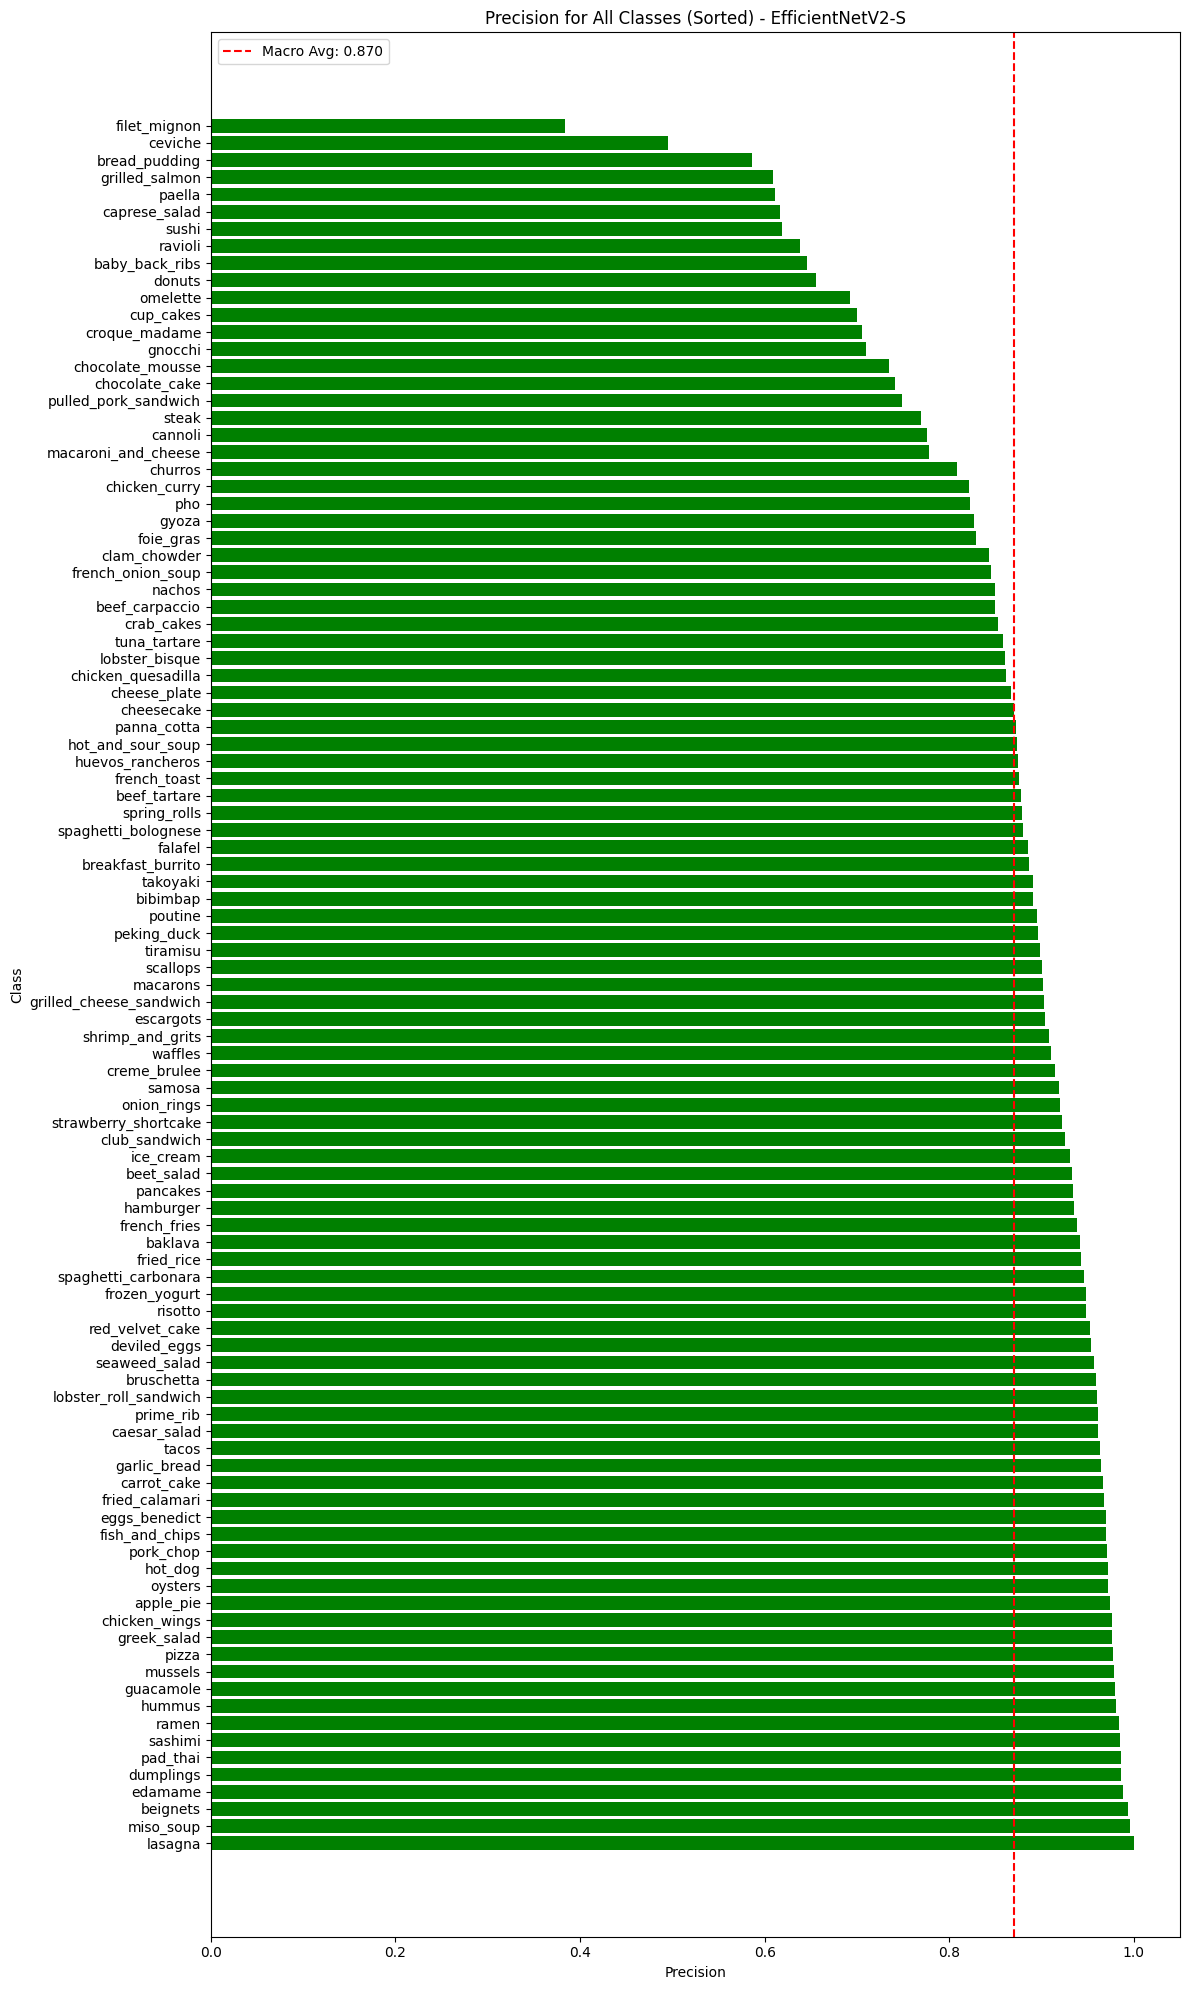

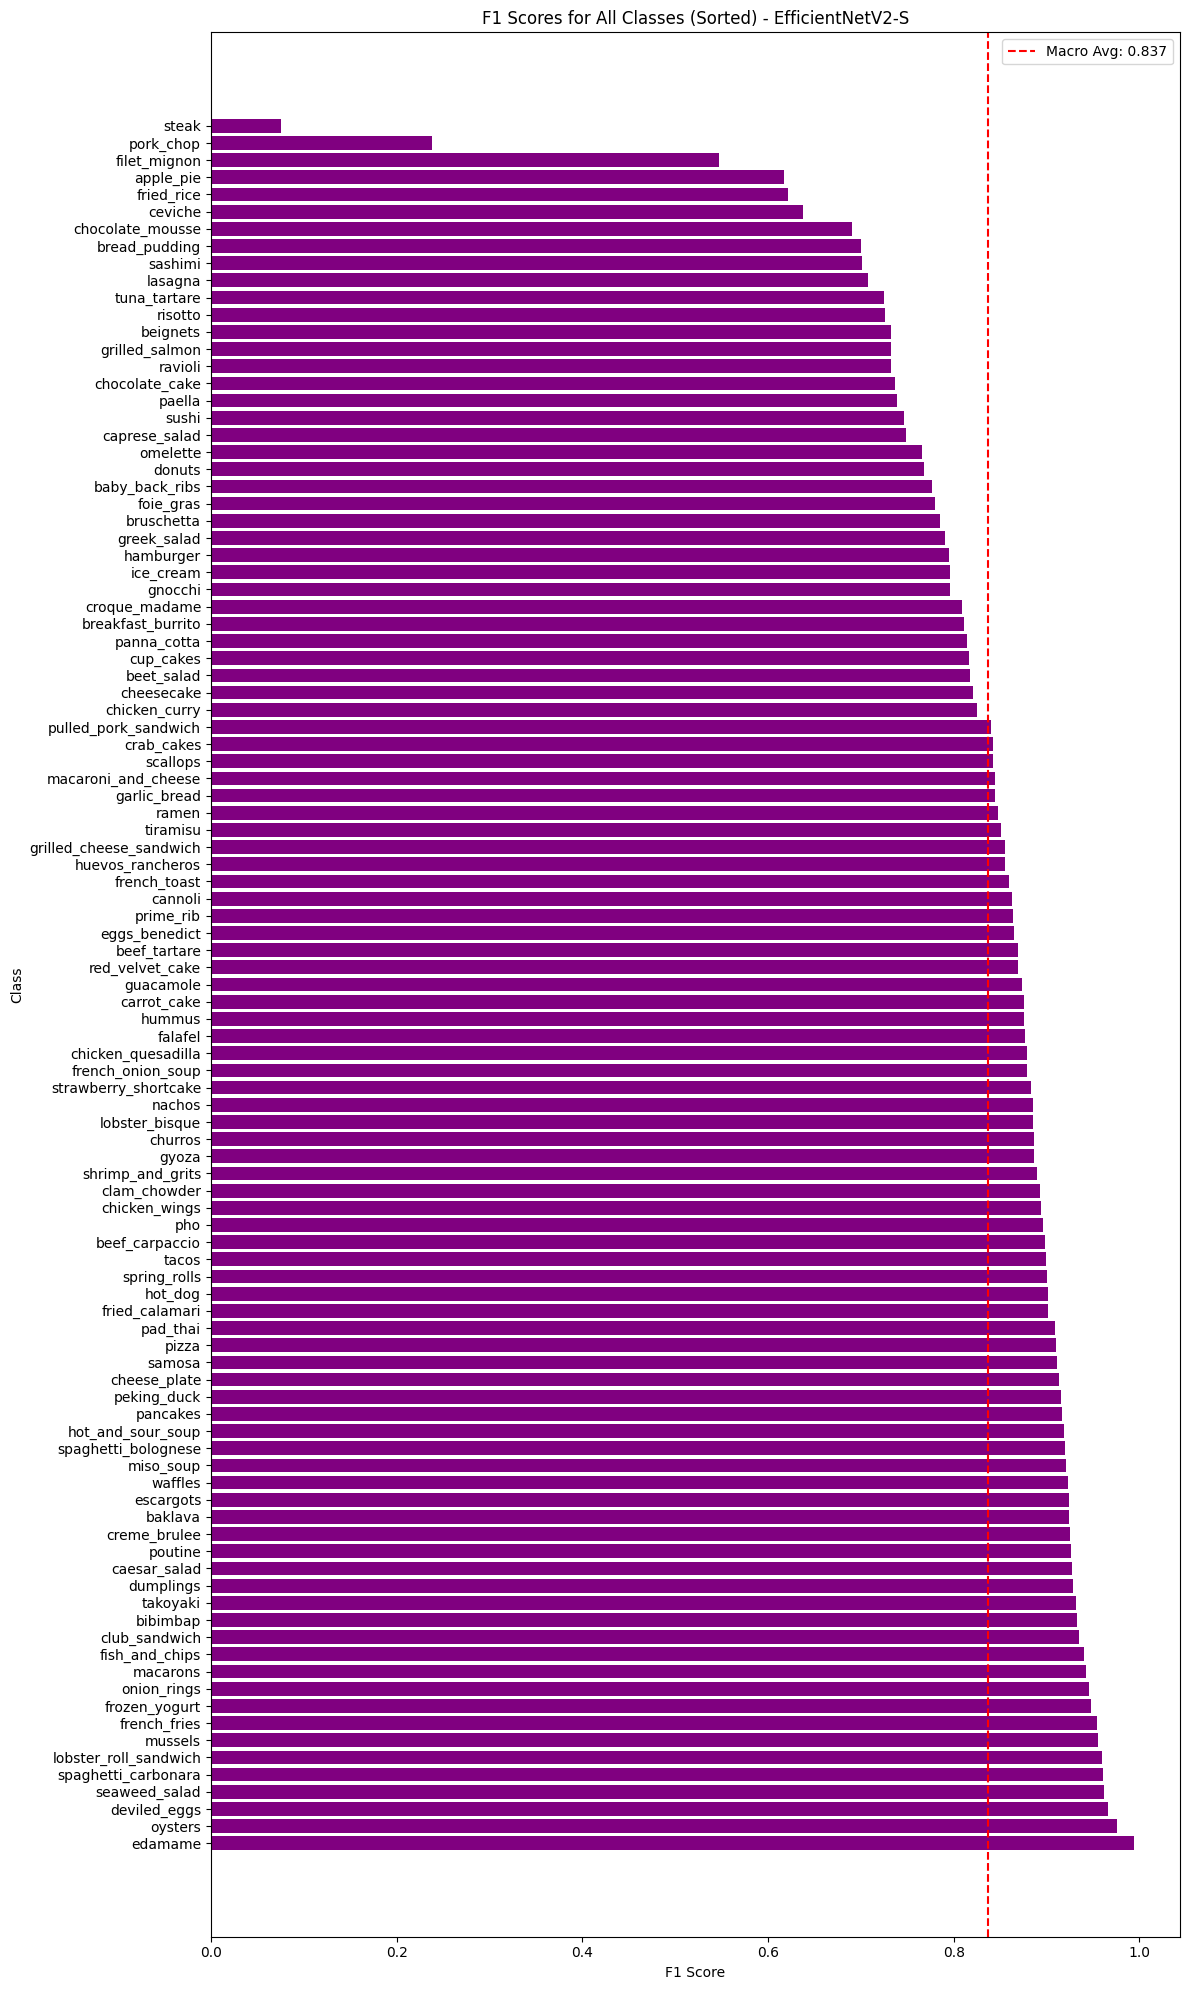

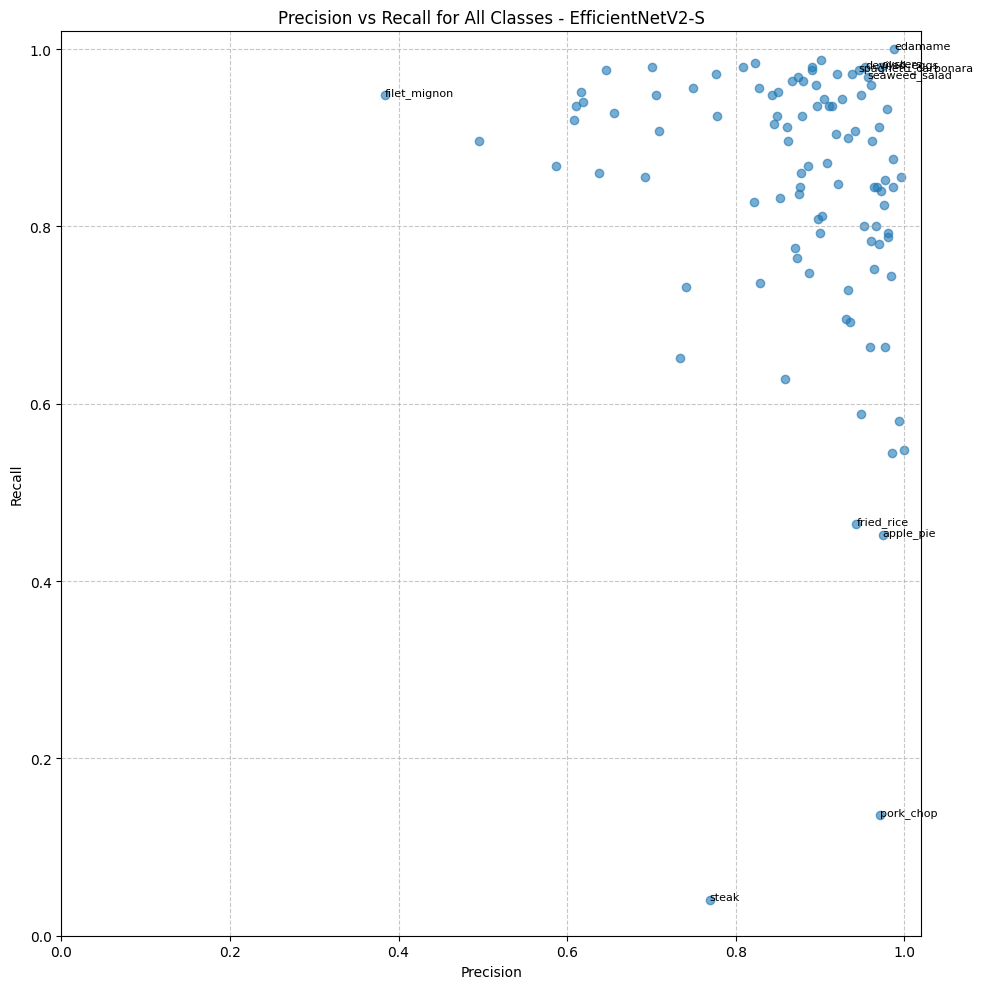

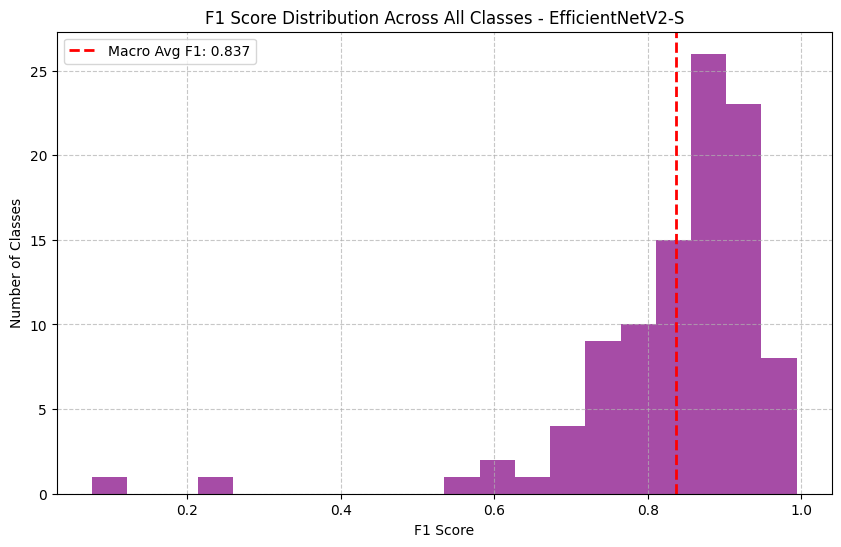

Full confusion matrix saved to /content/efficientnet_outputs/efficientnet_full_confusion_matrix.csv


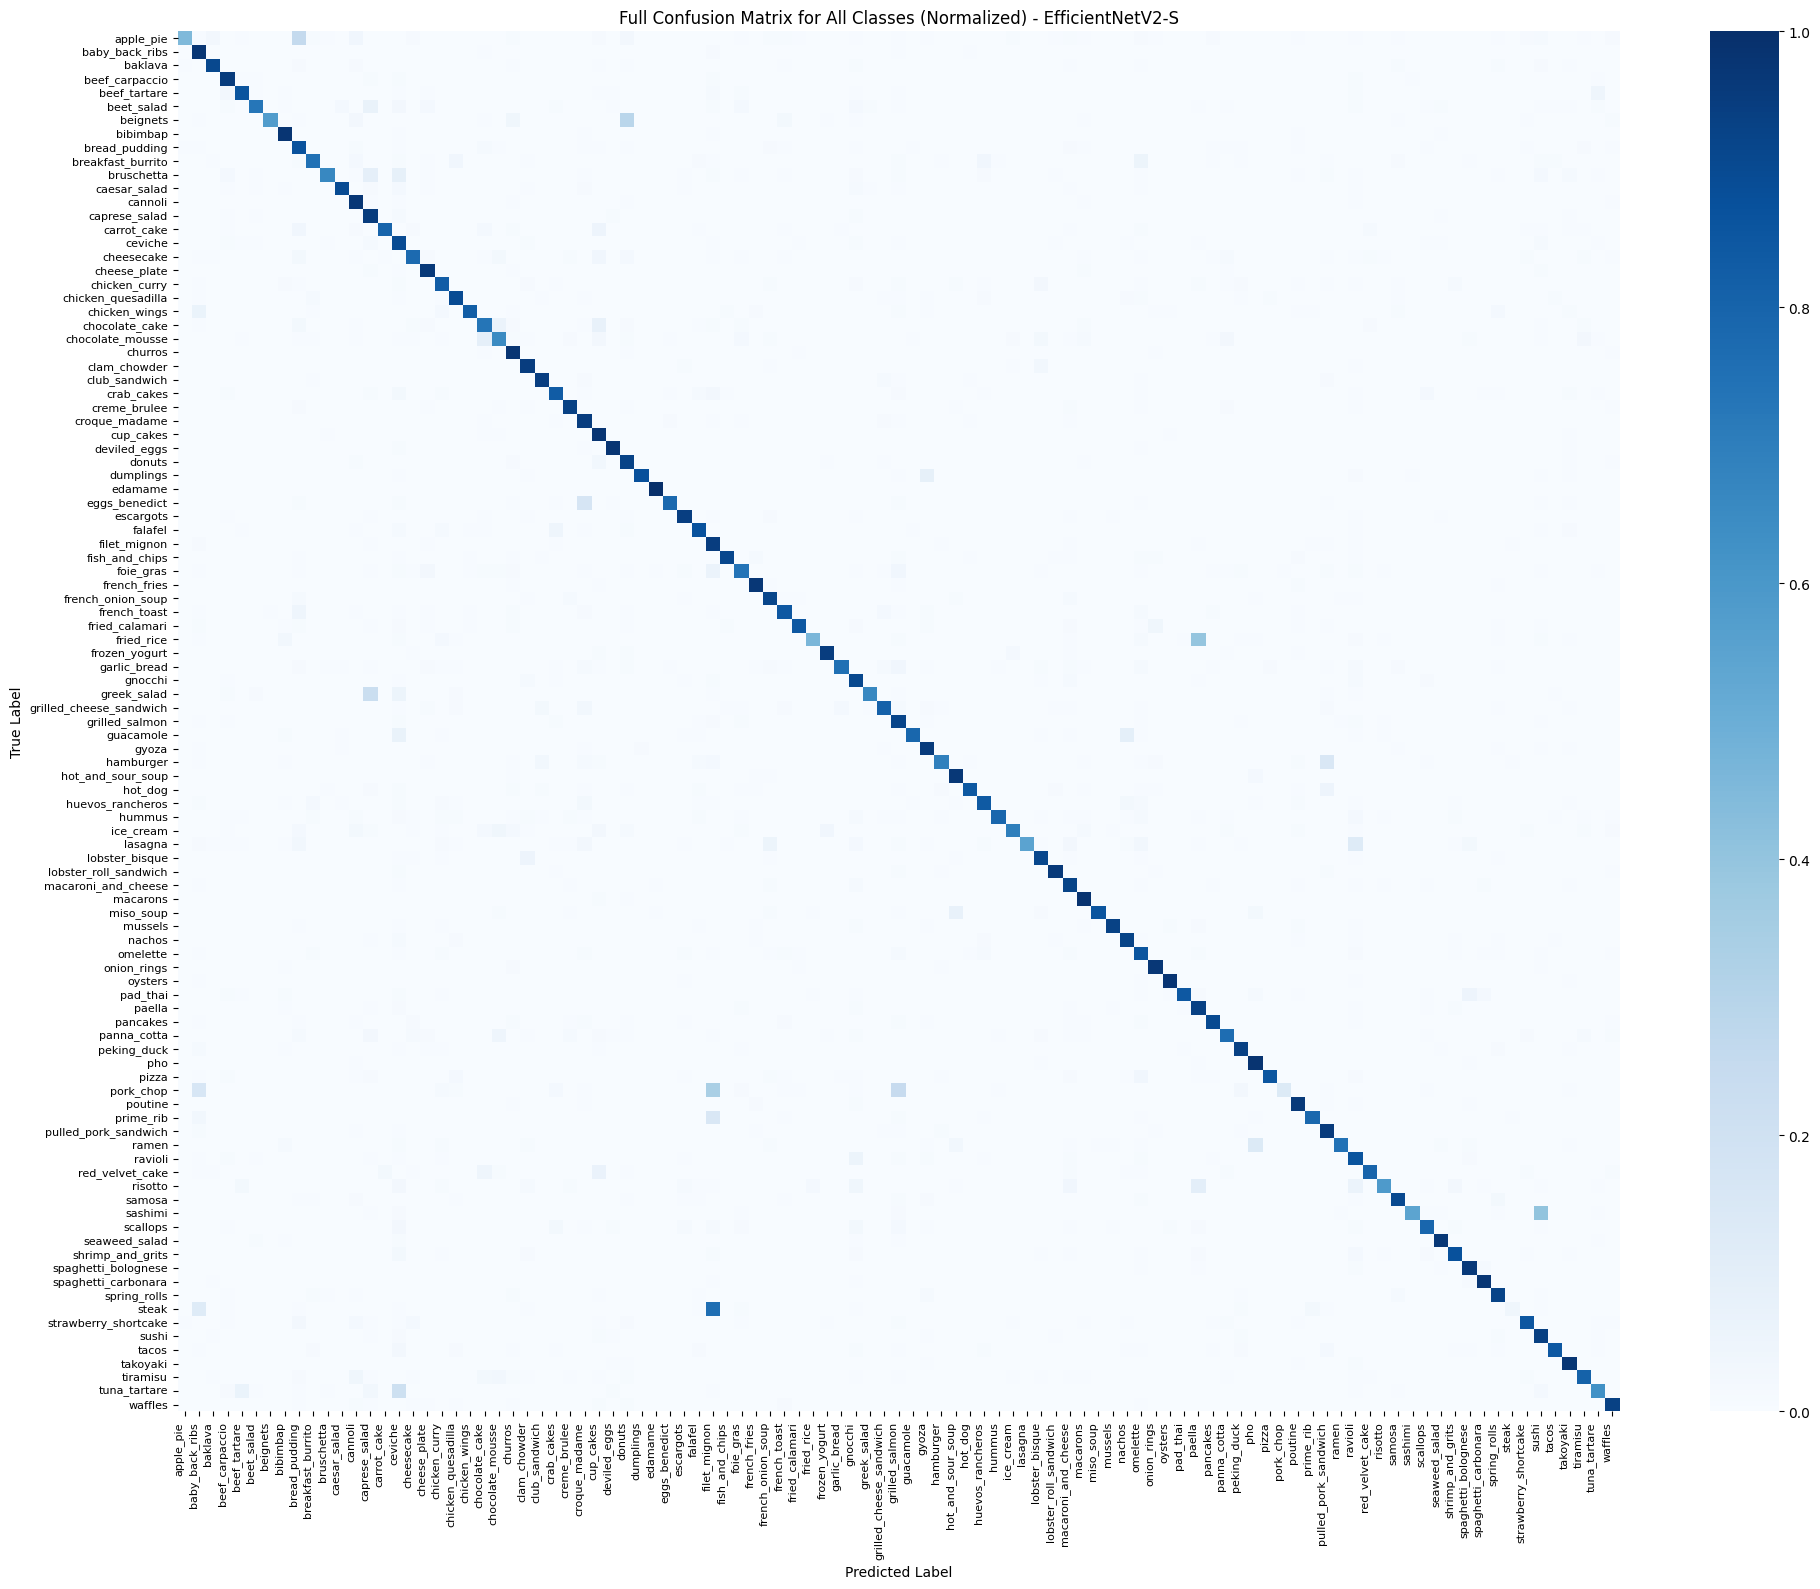

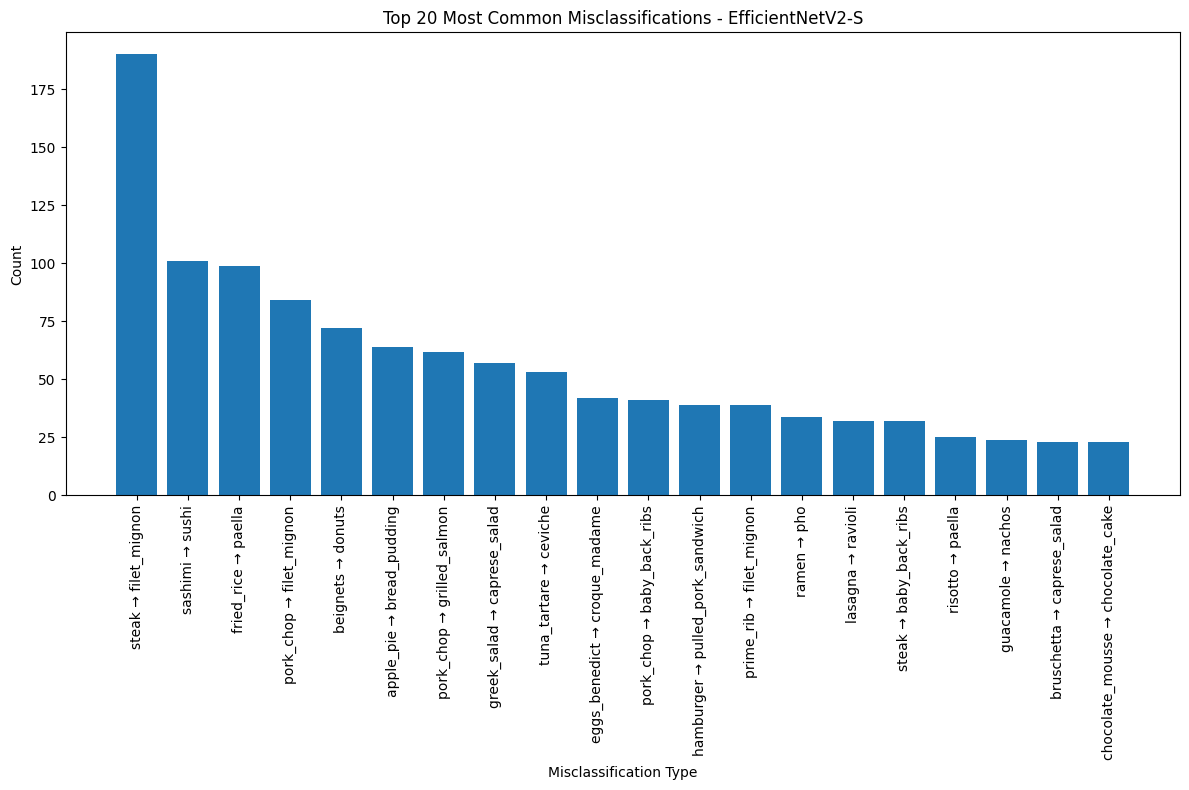


Evaluation of EfficientNetV2-S model completed successfully!


In [ ]:
# ============================================================
# Comprehensive Evaluation for EfficientNetV2-S Food-101 Model
# ============================================================

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

# Create output directory
OUTPUT_DIR = "/content/efficientnet_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("\n----------------------------------------")
print("Starting comprehensive model evaluation...")
print("----------------------------------------\n")

# Get class names from dataset
food_classes = ds["train"].features["label"].names
num_classes = len(food_classes)

# ---------- Create Evaluation Dataset ----------
def create_eval_dataset():
    """
    Create a clean dataset specifically for evaluation with proper preprocessing
    but no augmentation.

    Returns:
        TensorFlow dataset configured for evaluation
    """
    def gen():
        for item in ds["validation"]:
            yield item["image"]["bytes"], item["label"]

    eval_ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img_bytes, label):
        """Decode and preprocess image bytes without augmentation"""
        try:
            img = tf.io.decode_jpeg(img_bytes, channels=3)
        except:
            return tf.zeros([IMG, IMG, 3], tf.float32), tf.constant(-1, tf.int64)

        # Resize and normalize consistently with training
        img = tf.image.resize(img, (IMG, IMG), method="bilinear")
        img = tf.image.convert_image_dtype(img, tf.float32)  # Scale to [0,1]
        img = tf.cast(img, policy_dtype)
        return img, label

    # Set up dataset pipeline for evaluation
    eval_ds = (
        eval_ds
        .map(preprocess, AUTOT)
        .filter(lambda x, y: y > -1)  # Remove corrupted images
        .batch(BATCH // 2)  # Use smaller batch size for evaluation
        .prefetch(AUTOT)
    )

    return eval_ds

# ---------- Run Predictions ----------
# Initialize containers for evaluation results
all_labels = []
all_predictions = []
all_probs = []

print("Running predictions on validation set...")
eval_ds = create_eval_dataset()

# Generate predictions with progress tracking
for batch_images, batch_labels in tqdm(eval_ds, desc="Evaluating"):
    # Get model predictions
    batch_probs = model.predict(batch_images, verbose=0)
    batch_preds = tf.argmax(batch_probs, axis=1).numpy()

    # Store results
    all_labels.extend(batch_labels.numpy())
    all_predictions.extend(batch_preds)
    all_probs.extend(batch_probs)

# ---------- Calculate Metrics ----------
# Convert to numpy arrays for metrics calculation
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

print("Calculating metrics...")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate per-class metrics
per_class_precision = precision_score(all_labels, all_predictions, average=None)
per_class_recall = recall_score(all_labels, all_predictions, average=None)
per_class_f1 = f1_score(all_labels, all_predictions, average=None)

# Get support (number of samples) for each class
unique_labels, label_counts = np.unique(all_labels, return_counts=True)
per_class_support = np.zeros(num_classes, dtype=int)
for i, count in zip(unique_labels, label_counts):
    per_class_support[i] = count

# Create DataFrame with per-class metrics
class_metrics = pd.DataFrame({
    'Class': food_classes,
    'Precision': per_class_precision.round(4),
    'Recall': per_class_recall.round(4),
    'F1-Score': per_class_f1.round(4),
    'Support': per_class_support
})

# Sort by Recall (high to low)
sorted_metrics = class_metrics.sort_values('Recall', ascending=False)

# ---------- Overall Metrics ----------
# Calculate overall classification metrics
accuracy = np.mean(all_labels == all_predictions)
precision_macro = precision_score(all_labels, all_predictions, average='macro')
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
f1_macro = f1_score(all_labels, all_predictions, average='macro')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

# Calculate Top-5 accuracy
top5_correct = 0
for i, true_label in enumerate(all_labels):
    top5_indices = np.argsort(all_probs[i])[-5:]
    if true_label in top5_indices:
        top5_correct += 1
top5_accuracy = top5_correct / len(all_labels)

# Create overall metrics summary DataFrame
overall_metrics = pd.DataFrame([
    {'Class': 'accuracy', 'Precision': '', 'Recall': '', 'F1-Score': round(accuracy, 4), 'Support': len(all_labels)},
    {'Class': 'top-5 accuracy', 'Precision': '', 'Recall': '', 'F1-Score': round(top5_accuracy, 4), 'Support': len(all_labels)},
    {'Class': 'macro avg', 'Precision': round(precision_macro, 4), 'Recall': round(recall_macro, 4), 'F1-Score': round(f1_macro, 4), 'Support': len(all_labels)},
    {'Class': 'weighted avg', 'Precision': round(precision_weighted, 4), 'Recall': round(recall_weighted, 4), 'F1-Score': round(f1_weighted, 4), 'Support': len(all_labels)}
])

# ---------- Display Results ----------
# Print detailed class metrics
print("\nAll Classes Metrics (Sorted by Recall High to Low):")
print(sorted_metrics.to_string(index=False))

# Print summary metrics
print("\n")  # Empty line
print(overall_metrics.to_string(index=False))

# Save metrics to CSV
metrics_file = f"{OUTPUT_DIR}/efficientnet_metrics_by_recall.csv"
pd.concat([sorted_metrics, overall_metrics]).to_csv(metrics_file, index=False)
print(f"\nFull metrics table saved to: {metrics_file}")

# ---------- Generate Visualizations ----------
print("\nGenerating visualizations...")

# 1. Class Recall Visualization
plt.figure(figsize=(12, 20))
sorted_by_recall = class_metrics.sort_values('Recall', ascending=False)
plt.barh(sorted_by_recall['Class'], sorted_by_recall['Recall'], color='blue')
plt.axvline(x=recall_macro, color='red', linestyle='--', label=f'Macro Avg: {recall_macro:.3f}')
plt.title('Recall for All Classes (Sorted) - EfficientNetV2-S')
plt.xlabel('Recall')
plt.ylabel('Class')
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_all_recall.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Class Precision Visualization
plt.figure(figsize=(12, 20))
sorted_by_precision = class_metrics.sort_values('Precision', ascending=False)
plt.barh(sorted_by_precision['Class'], sorted_by_precision['Precision'], color='green')
plt.axvline(x=precision_macro, color='red', linestyle='--', label=f'Macro Avg: {precision_macro:.3f}')
plt.title('Precision for All Classes (Sorted) - EfficientNetV2-S')
plt.xlabel('Precision')
plt.ylabel('Class')
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_all_precision.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Class F1-Score Visualization
plt.figure(figsize=(12, 20))
sorted_by_f1 = class_metrics.sort_values('F1-Score', ascending=False)
plt.barh(sorted_by_f1['Class'], sorted_by_f1['F1-Score'], color='purple')
plt.axvline(x=f1_macro, color='red', linestyle='--', label=f'Macro Avg: {f1_macro:.3f}')
plt.title('F1 Scores for All Classes (Sorted) - EfficientNetV2-S')
plt.xlabel('F1 Score')
plt.ylabel('Class')
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_all_f1_scores.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Precision-Recall Scatter Plot
plt.figure(figsize=(10, 10))
plt.scatter(per_class_precision, per_class_recall, alpha=0.6)

# Add class labels to specific points (top and bottom performers)
top5_f1 = sorted_by_f1.head(5)
bottom5_f1 = sorted_by_f1.tail(5)

for _, row in pd.concat([top5_f1, bottom5_f1]).iterrows():
    cls = row['Class']
    prec = row['Precision']
    rec = row['Recall']
    plt.annotate(cls, (prec, rec), fontsize=8)

plt.xlim(0, 1.02)
plt.ylim(0, 1.02)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall for All Classes - EfficientNetV2-S')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_precision_recall_scatter.png", dpi=300)
plt.show()

# 5. F1-Score Distribution Histogram
plt.figure(figsize=(10, 6))
plt.hist(per_class_f1, bins=20, alpha=0.7, color='purple')
plt.axvline(f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro Avg F1: {f1_macro:.3f}')
plt.title('F1 Score Distribution Across All Classes - EfficientNetV2-S')
plt.xlabel('F1 Score')
plt.ylabel('Number of Classes')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{OUTPUT_DIR}/efficientnet_f1_distribution.png", dpi=300)
plt.show()

# ---------- Confusion Matrix Analysis ----------
# Save the full confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=food_classes, columns=food_classes)
cm_df.to_csv(f"{OUTPUT_DIR}/efficientnet_full_confusion_matrix.csv")
print(f"Full confusion matrix saved to {OUTPUT_DIR}/efficientnet_full_confusion_matrix.csv")

# Create normalized confusion matrix for visualization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap of confusion matrix (normalized)
plt.figure(figsize=(20, 16))
sns.heatmap(cm_norm, cmap="Blues", xticklabels=food_classes, yticklabels=food_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Full Confusion Matrix for All Classes (Normalized) - EfficientNetV2-S')
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_full_confusion_matrix.png", dpi=300)
plt.show()

# ---------- Top Misclassifications Analysis ----------
# Make a copy and remove diagonal elements to focus on errors
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # Zero out the diagonal (correct predictions)

# Find and sort the top misclassifications
top_misclassifications = []
for i in range(len(cm_copy)):
    for j in range(len(cm_copy)):
        if i != j and cm_copy[i, j] > 0:  # Only include errors
            top_misclassifications.append((i, j, cm_copy[i, j]))

# Sort by count (descending) and take top 20
top_misclassifications.sort(key=lambda x: x[2], reverse=True)
top_misclassifications = top_misclassifications[:20]

# Create a DataFrame for top misclassifications
misclass_df = pd.DataFrame({
    'True Class': [food_classes[i] for i, j, _ in top_misclassifications],
    'Predicted Class': [food_classes[j] for i, j, _ in top_misclassifications],
    'Count': [count for _, _, count in top_misclassifications]
})

# Save to CSV
misclass_df.to_csv(f"{OUTPUT_DIR}/efficientnet_top_misclassifications.csv", index=False)

# Visualize top misclassifications
plt.figure(figsize=(12, 8))
plt.bar(range(len(misclass_df)), misclass_df['Count'])
plt.xticks(range(len(misclass_df)),
           [f"{true} → {pred}" for true, pred in zip(misclass_df['True Class'], misclass_df['Predicted Class'])],
           rotation=90)
plt.xlabel('Misclassification Type')
plt.ylabel('Count')
plt.title('Top 20 Most Common Misclassifications - EfficientNetV2-S')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_top_misclassifications.png", dpi=300)
plt.show()

print("\nEvaluation of EfficientNetV2-S model completed successfully!")

# Model 2: #
# ============================================================
# Food-101 Classification with ResNet50 on Google Colab
# ============================================================
"""
This notebook implements a food image classification model using ResNet50
on the Food-101 dataset with a two-stage training approach:

1. First stage: Train with frozen backbone using smaller images (224x224)
2. Second stage: Fine-tune with unfrozen layers using larger images (512x512)

The implementation includes:
- Balanced dataset creation
- MixUp data augmentation
- Progressive image size training
- Model checkpointing and early stopping
- Comprehensive visualization of training progress

The model achieves 84.72% Top-1 accuracy on the Food-101 validation set.

检查GPU可用性:
GPU是否可用: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow版本: 2.18.0
加载Food101数据集...
数据集加载完成: 101个类别
创建了训练集索引: 75750样本
创建了验证集索引: 25250样本
开始阶段1训练 (冻结基础模型)...
Epoch 1/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 316s 118ms/step - accuracy: 0.3360 - loss: 3.3767 - val_accuracy: 0.6184 - val_loss: 2.1473
Epoch 2/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 279s 118ms/step - accuracy: 0.4998 - loss: 2.6705 - val_accuracy: 0.6444 - val_loss: 2.0743
Epoch 3/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 276s 117ms/step - accuracy: 0.5355 - loss: 2.5581 - val_accuracy: 0.6603 - val_loss: 2.0124
Epoch 4/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 276s 117ms/step - accuracy: 0.5502 - loss: 2.5021 - val_accuracy: 0.6694 - val_loss: 1.9906
Epoch 5/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 276s 116ms/step - accuracy: 0.5678 - loss: 2.4398 - val_accuracy: 0.6692 - val_loss: 1.9772
Epoch 6/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 276s 117ms/step - accuracy: 0.5868 - loss: 2.3864 - val_accuracy: 0.6743 - val_loss: 1.9574
E

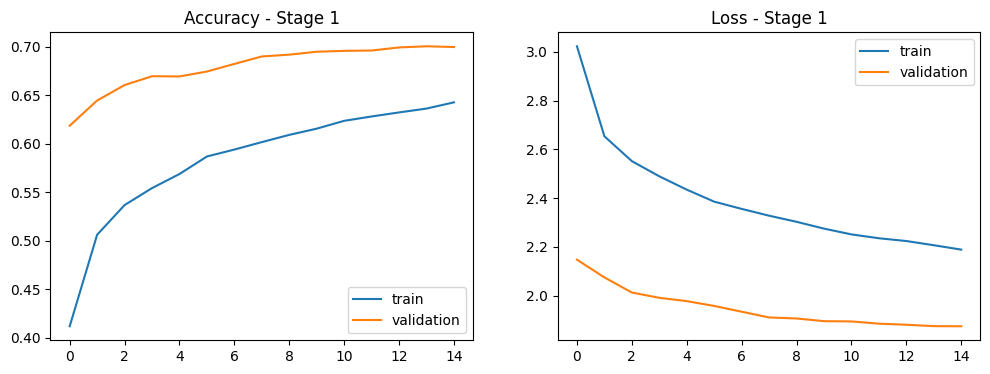

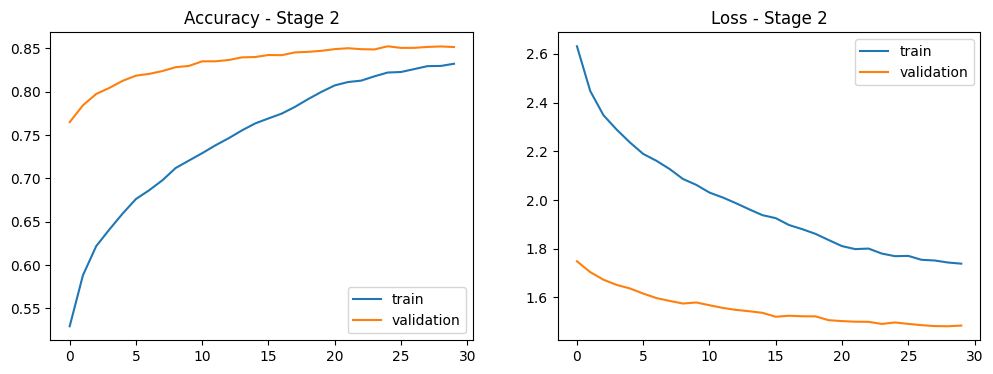

In [ ]:
# ============================================================
# Food-101 Classification with ResNet50 on Google Colab
# ============================================================

import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import math
from google.colab import drive

# ---------- Environment Setup ----------
# Create output directory for saving models and visualizations
OUTPUT_DIR = "/content/outputs"  # Local Colab directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configure logging and silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
logging.getLogger('absl').setLevel('ERROR')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- GPU Availability Check ----------
print("Checking GPU availability:")
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# ---------- Load Food-101 Dataset ----------
print("Loading Food-101 dataset...")
dataset = load_dataset("ethz/food101")
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"Dataset loaded: {num_classes} classes")

# ---------- Create Balanced Dataset ----------
def create_balanced_indices(split, per_class):
    """
    Create indices for a balanced dataset with equal samples per class

    Args:
        split: Dataset split ('train' or 'validation')
        per_class: Number of samples to include per class

    Returns:
        List of indices for balanced dataset
    """
    class_to_indices = {i: [] for i in range(num_classes)}
    for i, sample in enumerate(split):
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
    indices = sum([class_to_indices[i] for i in range(num_classes)], [])
    random.shuffle(indices)
    return indices

train_indices = create_balanced_indices(dataset['train'], 750)
val_indices = create_balanced_indices(dataset['validation'], 250)
print(f"Created training indices: {len(train_indices)} samples")
print(f"Created validation indices: {len(val_indices)} samples")

# ---------- Data Augmentation with MixUp ----------
def apply_mixup(images, labels, alpha=0.2):
    """
    Apply MixUp augmentation to batch of images

    MixUp creates new training examples by linearly interpolating between
    two random examples from the batch.

    Args:
        images: Batch of images
        labels: Batch of one-hot encoded labels
        alpha: Alpha parameter for beta distribution

    Returns:
        Tuple of mixed images and mixed labels
    """
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    beta = tf.random.gamma([batch_size], alpha) / tf.reduce_sum(tf.random.gamma([batch_size], alpha), axis=0)
    beta = tf.reshape(beta, (batch_size, 1, 1, 1))
    beta_y = tf.reshape(beta, (batch_size, 1))
    return beta * images + (1 - beta) * tf.gather(images, indices), beta_y * labels + (1 - beta_y) * tf.gather(labels, indices)

def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True, mixup=False):
    """
    Create a TensorFlow dataset with preprocessing and augmentation

    Args:
        split: Dataset split ('train' or 'validation')
        indices: Indices to include in the dataset
        image_size: Target image size
        batch_size: Batch size
        is_training: Whether to apply training augmentations
        mixup: Whether to apply MixUp augmentation

    Returns:
        TensorFlow dataset ready for training
    """
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            # Handle grayscale and RGBA images
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)  # Grayscale to RGB
            elif img.shape[-1] == 4:
                img = img[:, :, :3]  # RGBA to RGB
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        """Preprocess and augment images"""
        # Normalize pixel values to [0,1]
        img = tf.cast(img, tf.float32) / 255.0

        # Add padding for center crop later
        img = tf.image.resize(img, (image_size+32, image_size+32))

        if is_training:
            # Apply data augmentation
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
        else:
            # Center crop for validation
            img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)

        # One-hot encode labels
        label = tf.one_hot(label, num_classes)
        return img, label

    # Build dataset pipeline
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    if is_training and mixup:
        ds = ds.map(lambda x, y: apply_mixup(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ---------- Model Architecture ----------
def build_model(image_size=224, dropout=0.5, label_smooth=0.1, unfreeze_layers=0):
    """
    Build a ResNet50-based model with custom classification head

    Args:
        image_size: Input image size
        dropout: Dropout rate for regularization
        label_smooth: Label smoothing factor
        unfreeze_layers: Number of ResNet layers to unfreeze (0 = all frozen)

    Returns:
        Compiled TensorFlow model
    """
    # Load pre-trained ResNet50 model
    base = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )

    # Configure layer freezing
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    # Build model architecture
    model = tf.keras.Sequential([
        # Input and preprocessing
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x*255.)),

        # ResNet50 backbone
        base,

        # Classification head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Configure optimizer and loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3 if unfreeze_layers == 0 else 1e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    return model

# ---------- Training Function ----------
def train_model():
    """Train the model using a two-stage approach"""
    # Configuration
    BATCH_SIZE = 32
    IMAGE_SIZE1 = 224  # First stage image size
    IMAGE_SIZE2 = 512  # Second stage image size (higher resolution)

    # Setup TensorBoard for visualization
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=f"{OUTPUT_DIR}/logs",
        histogram_freq=1
    )

    # ---------- Stage 1: Feature Extraction ----------
    print("Starting Stage 1 training (frozen backbone)...")

    # Create datasets for first stage
    train_ds1 = create_dataset(
        dataset['train'],
        train_indices,
        image_size=IMAGE_SIZE1,
        batch_size=BATCH_SIZE,
        is_training=True,
        mixup=True
    )

    val_ds1 = create_dataset(
        dataset['validation'],
        val_indices,
        image_size=IMAGE_SIZE1,
        batch_size=BATCH_SIZE,
        is_training=False
    )

    # Create and train model
    model1 = build_model(
        image_size=IMAGE_SIZE1,
        dropout=0.3,
        label_smooth=0.1,
        unfreeze_layers=0
    )

    history1 = model1.fit(
        train_ds1,
        validation_data=val_ds1,
        steps_per_epoch=len(train_indices)//BATCH_SIZE,
        validation_steps=len(val_indices)//BATCH_SIZE,
        epochs=15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR}/best_stage1.keras', save_best_only=True),
            tensorboard_callback
        ]
    )

    # Visualize Stage 1 training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='train')
    plt.plot(history1.history['val_accuracy'], label='validation')
    plt.title('Accuracy - Stage 1')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='train')
    plt.plot(history1.history['val_loss'], label='validation')
    plt.title('Loss - Stage 1')
    plt.legend()

    plt.savefig(f'{OUTPUT_DIR}/history_stage1.png')

    # ---------- Stage 2: Fine-tuning ----------
    print("\nStarting Stage 2 training (fine-tuning)...")

    # Create datasets for second stage with higher resolution
    train_ds2 = create_dataset(
        dataset['train'],
        train_indices,
        image_size=IMAGE_SIZE2,  # Larger image size
        batch_size=BATCH_SIZE//2,  # Reduced batch size for memory
        is_training=True,
        mixup=True
    )

    val_ds2 = create_dataset(
        dataset['validation'],
        val_indices,
        image_size=IMAGE_SIZE2,
        batch_size=BATCH_SIZE//2,
        is_training=False
    )

    # Create new model with unfrozen layers and transfer weights
    model2 = build_model(
        image_size=IMAGE_SIZE2,
        dropout=0.5,  # Increased dropout
        label_smooth=0.1,
        unfreeze_layers=30  # Unfreeze the last 30 layers
    )
    model2.set_weights(model1.get_weights())  # Transfer weights from Stage 1

    # Add learning rate reduction callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train with fine-tuning
    history2 = model2.fit(
        train_ds2,
        validation_data=val_ds2,
        steps_per_epoch=len(train_indices)//(BATCH_SIZE//2),
        validation_steps=len(val_indices)//(BATCH_SIZE//2),
        epochs=30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR}/best_stage2.keras', save_best_only=True),
            tensorboard_callback,
            reduce_lr
        ]
    )

    # Visualize Stage 2 training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history2.history['accuracy'], label='train')
    plt.plot(history2.history['val_accuracy'], label='validation')
    plt.title('Accuracy - Stage 2')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history2.history['loss'], label='train')
    plt.plot(history2.history['val_loss'], label='validation')
    plt.title('Loss - Stage 2')
    plt.legend()

    plt.savefig(f'{OUTPUT_DIR}/history_stage2.png')

    # Save final model
    model2.save(f'{OUTPUT_DIR}/final_model.keras')
    print(f"Training completed, model saved to {OUTPUT_DIR}!")

# ---------- Run Training ----------
if __name__ == '__main__':
    train_model()

# ============================================================
# Food-101 ResNet50 Model Evaluation Script
# ============================================================

This script performs a comprehensive evaluation of the ResNet50 model
trained on the Food-101 dataset. It conducts the following analyses:

1. Full evaluation of model performance on the validation set
2. Per-class precision, recall, and F1-score metrics
3. Generation of multiple visualizations:
   - Class-wise performance metrics
   - Precision-recall scatter plots
   - F1-score distributions
   - Confusion matrix
   - Common misclassification analysis

All results are both displayed and saved to the output directory.

Loading Food101 dataset...
Loading inference model: /content/outputs/inference_model.keras

Starting evaluation...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluation Progress:   0%|          | 0/25250 [00:00<?, ?it/s]


Calculating metrics...

All Classes Metrics (Sorted by Recall High to Low):
                  Class  Precision  Recall  F1-Score  Support
                edamame     0.9960   0.996    0.9960      250
          frozen_yogurt     0.9104   0.976    0.9421      250
          seaweed_salad     0.9026   0.964    0.9323      250
                    pho     0.9091   0.960    0.9339      250
      hot_and_sour_soup     0.8914   0.952    0.9207      250
                sashimi     0.9084   0.952    0.9297      250
                  pizza     0.8815   0.952    0.9154      250
                oysters     0.9328   0.944    0.9384      250
               macarons     0.9793   0.944    0.9613      250
           deviled_eggs     0.9291   0.944    0.9365      250
               pad_thai     0.8969   0.940    0.9180      250
           french_fries     0.8577   0.940    0.8969      250
              cup_cakes     0.9000   0.936    0.9176      250
    spaghetti_bolognese     0.9317   0.928    0.9299   

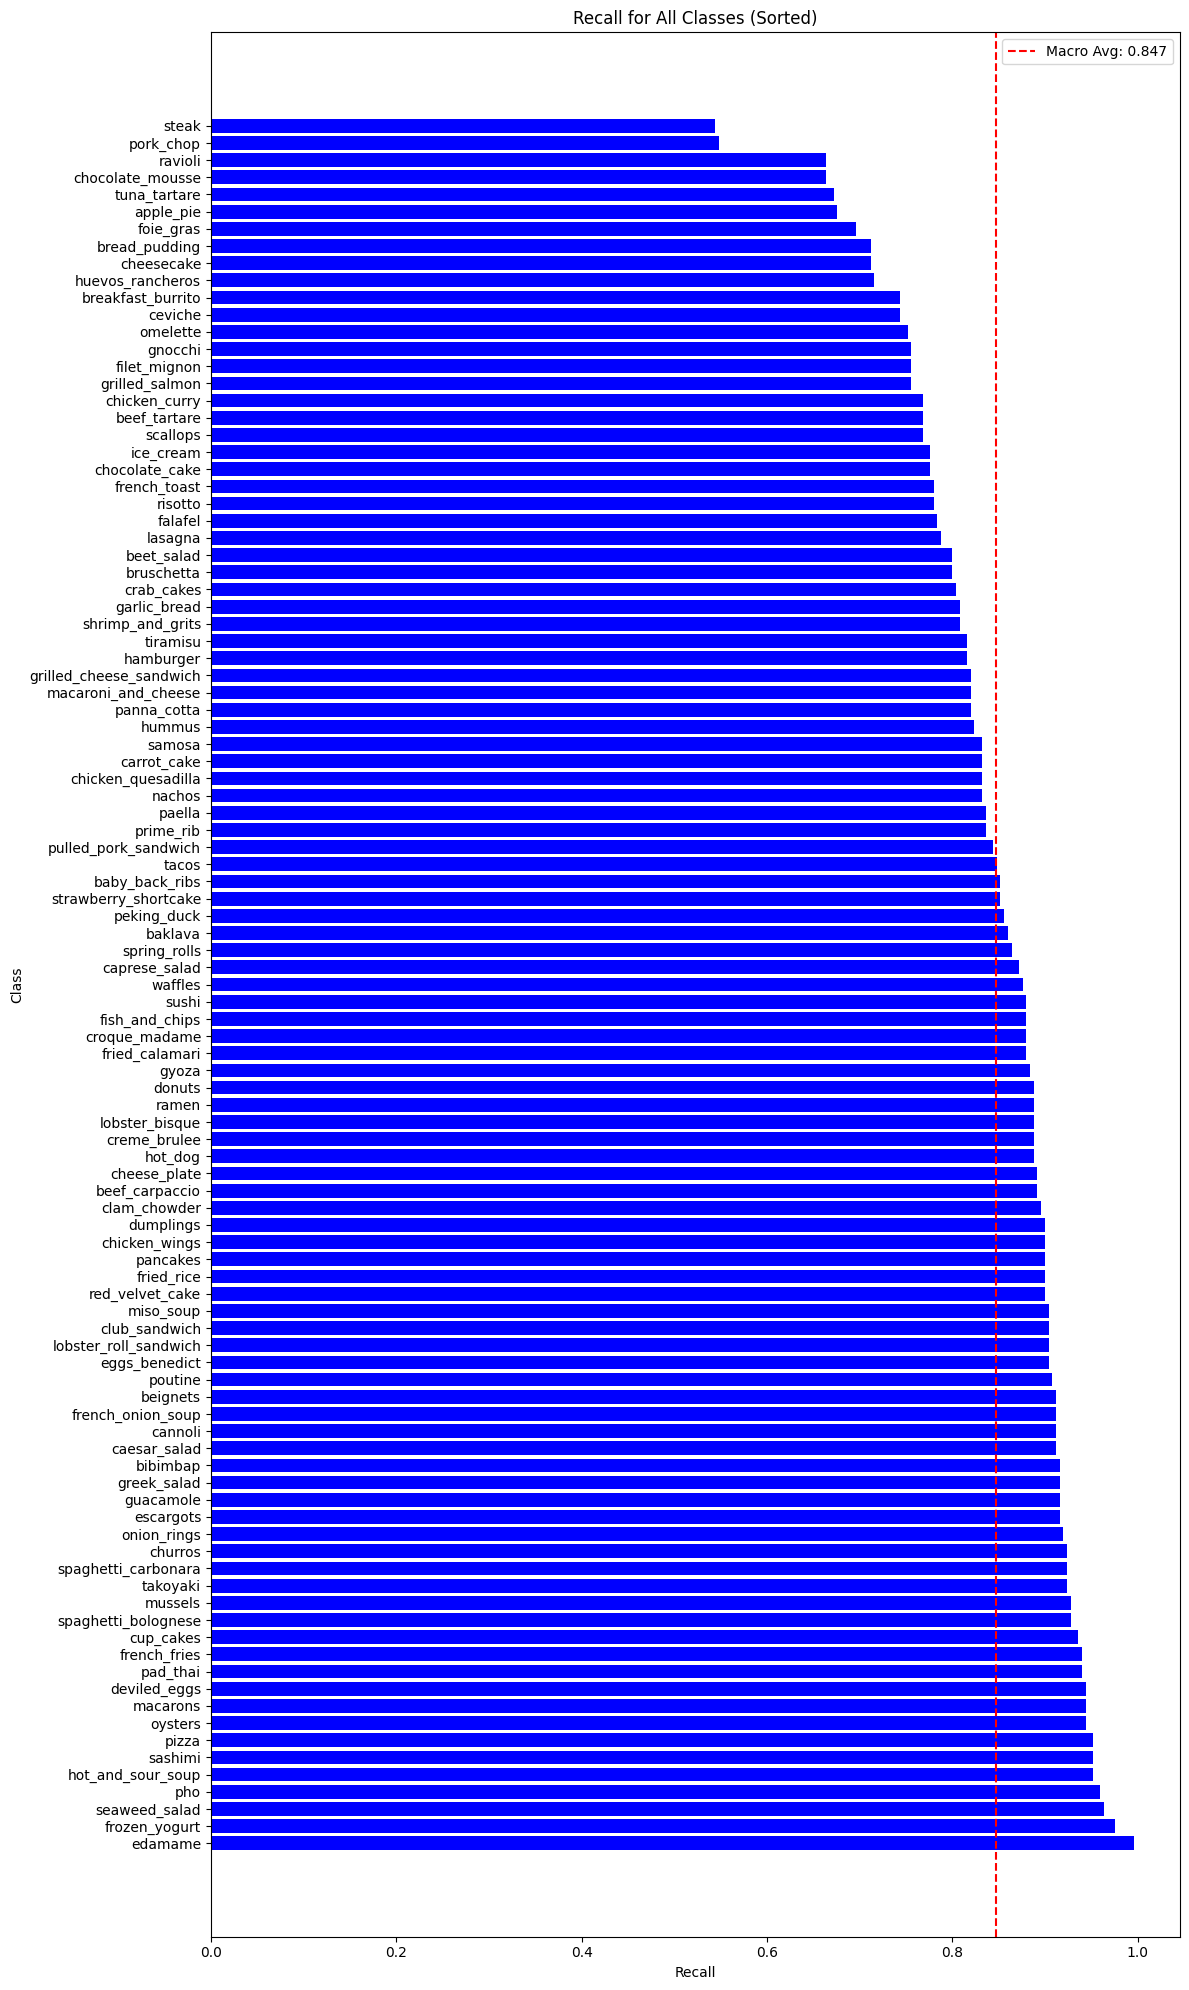

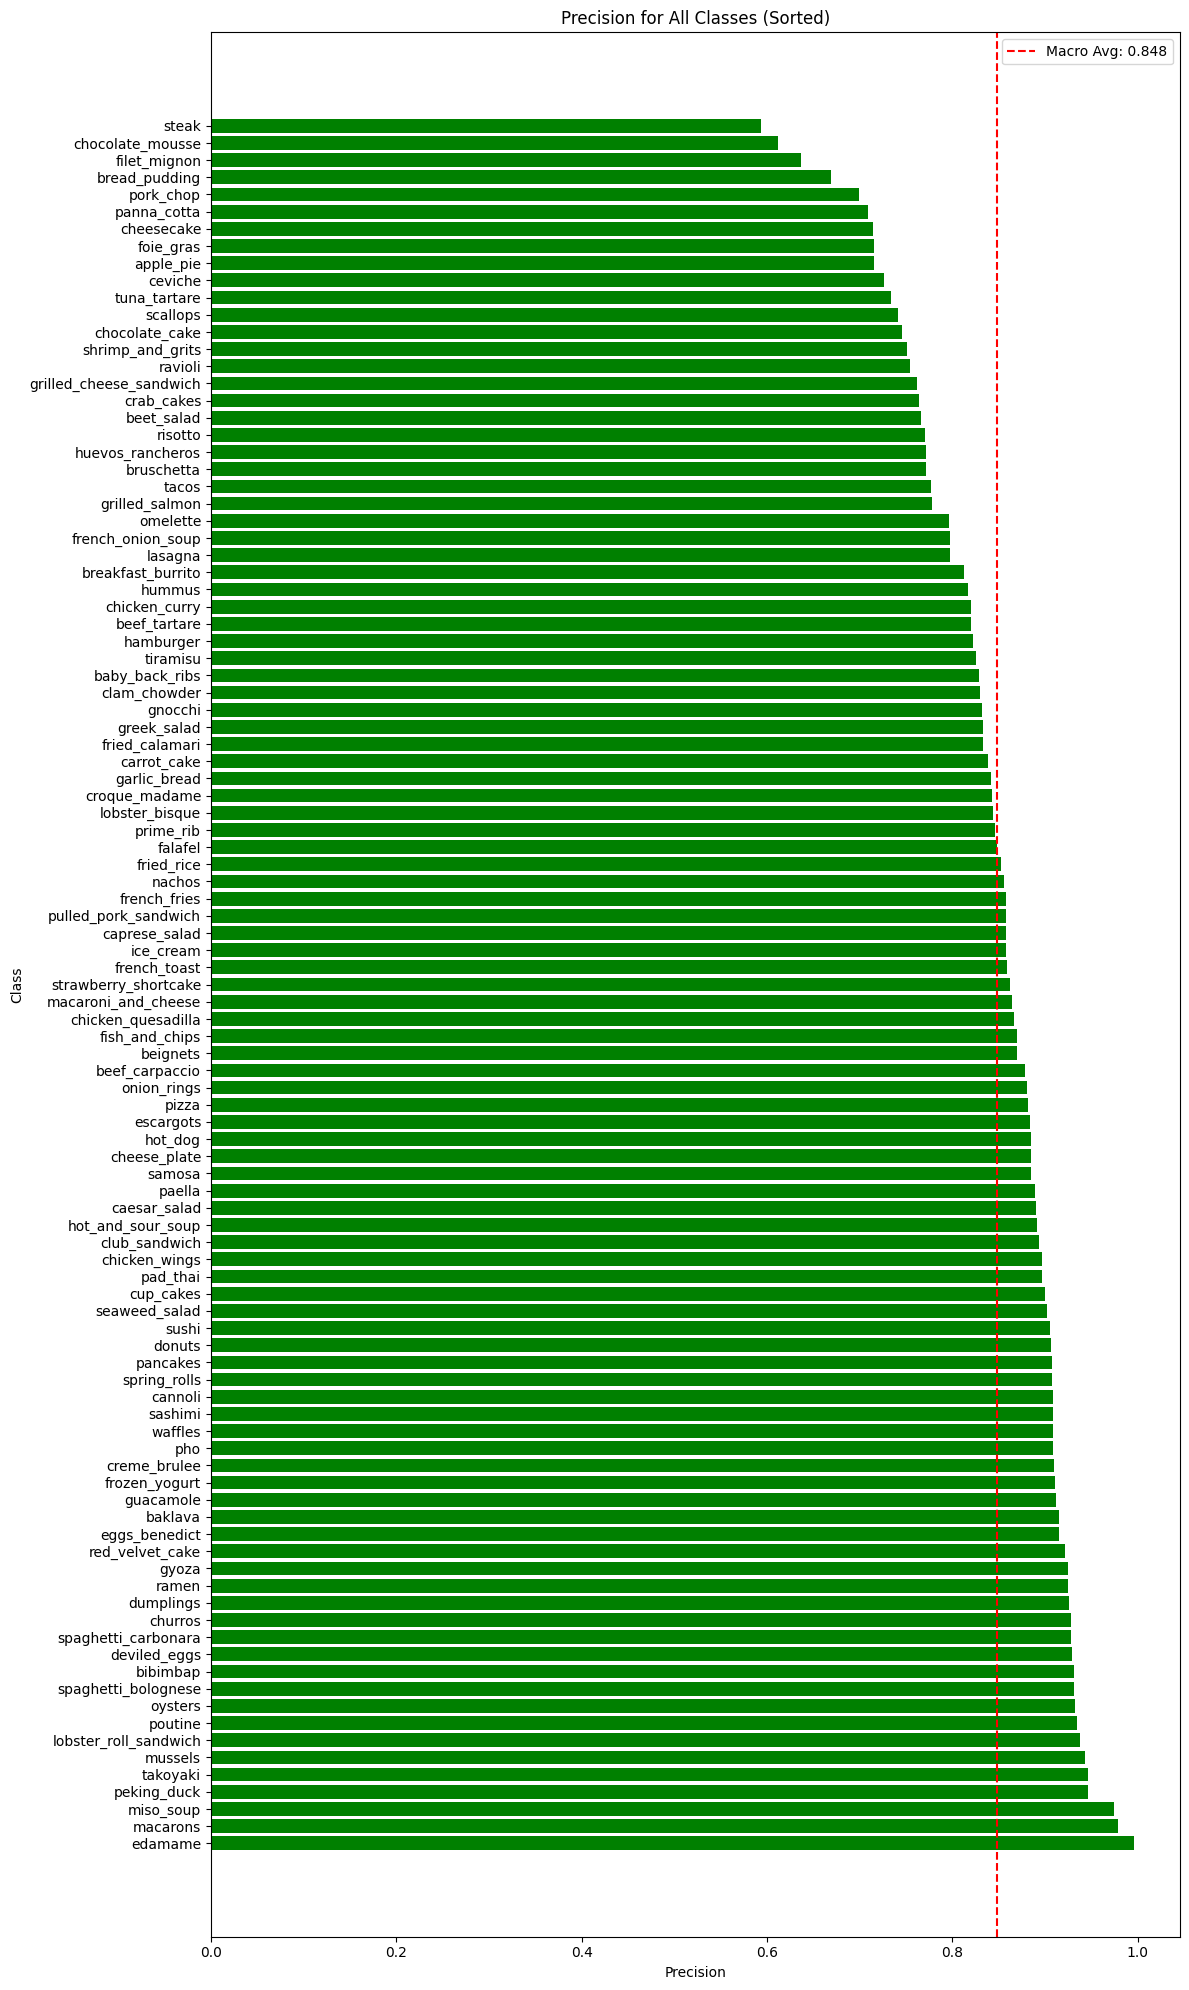

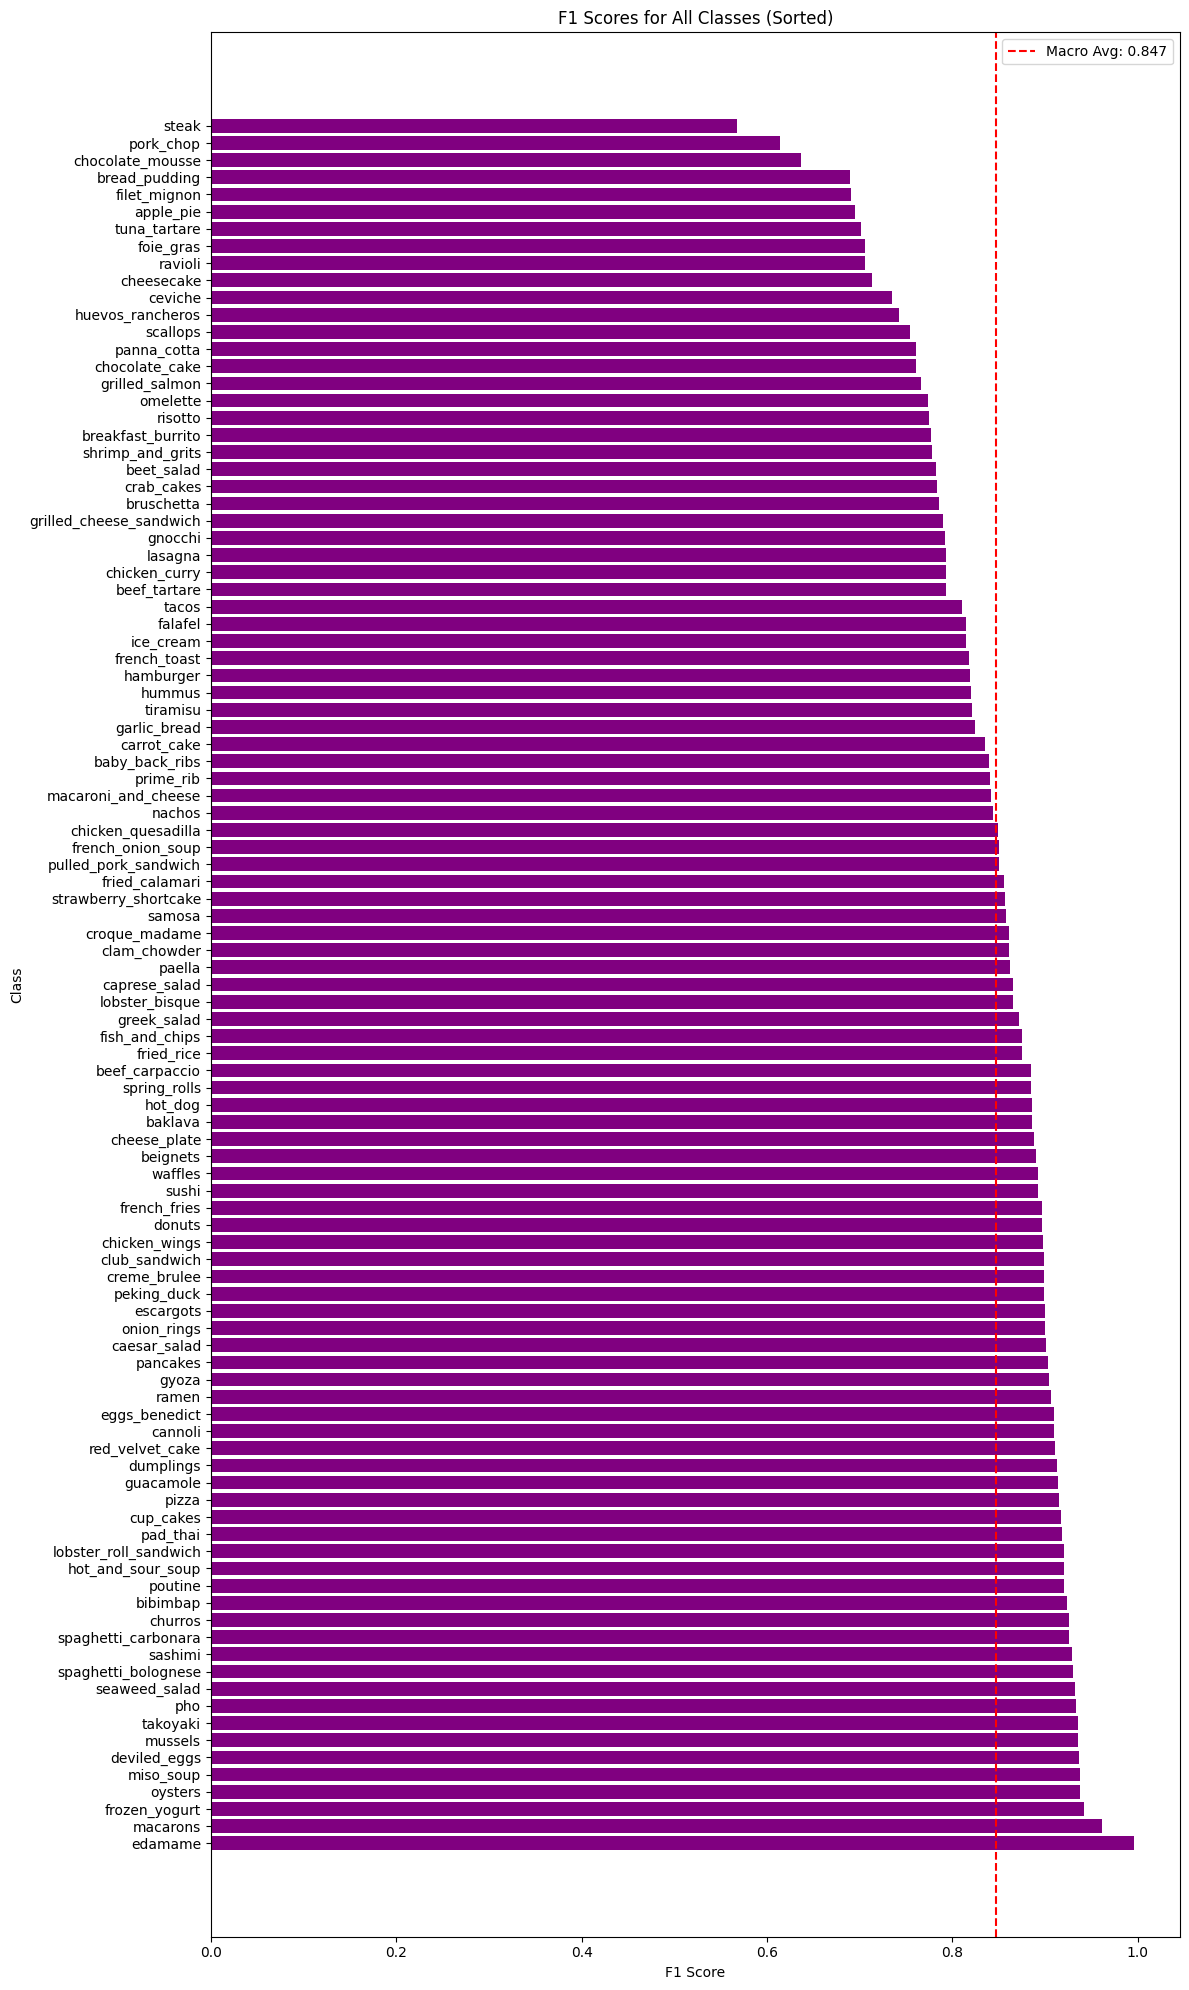

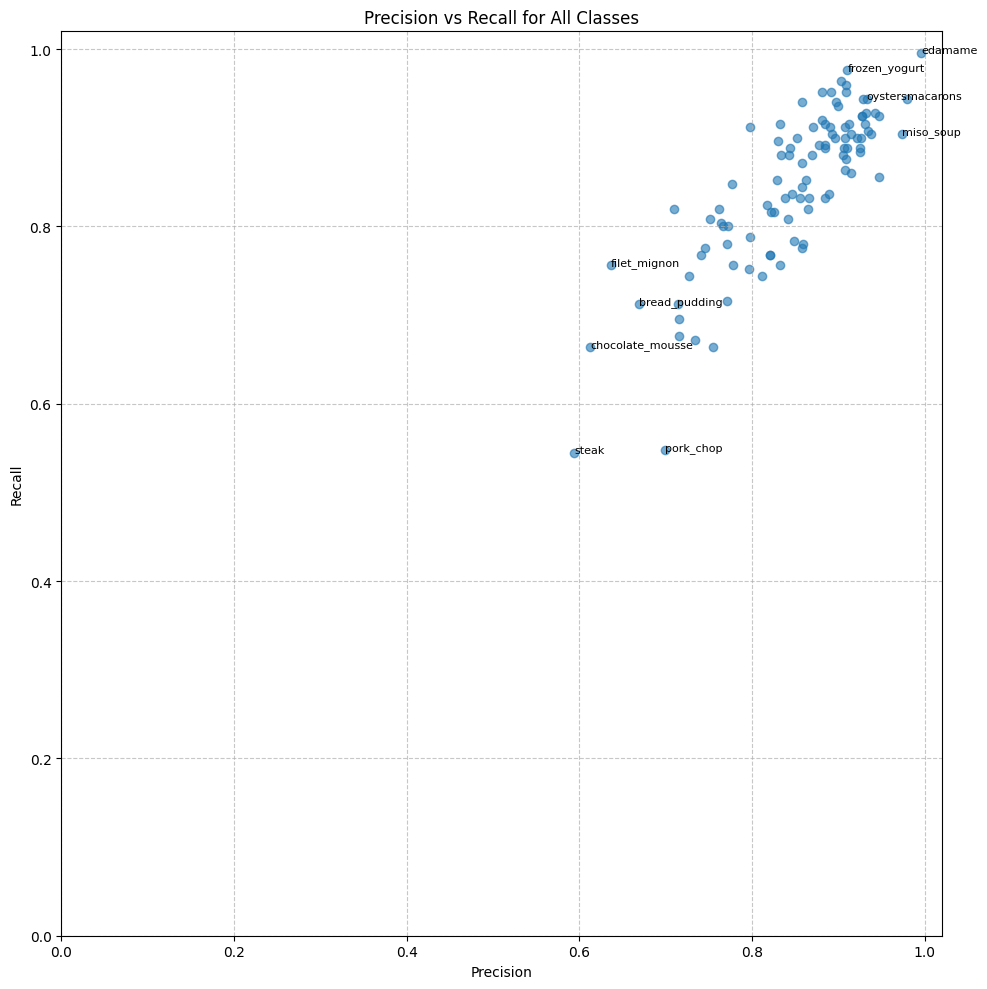

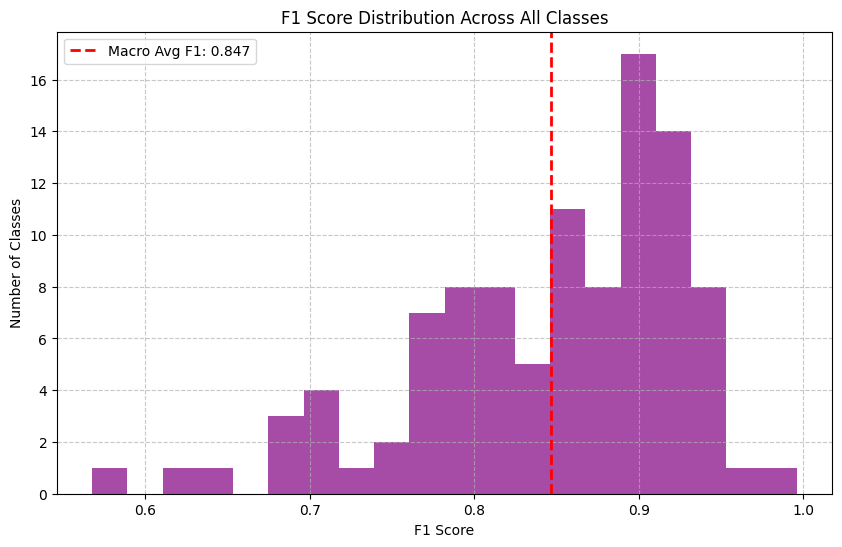

Full confusion matrix saved to /content/outputs/full_confusion_matrix.csv


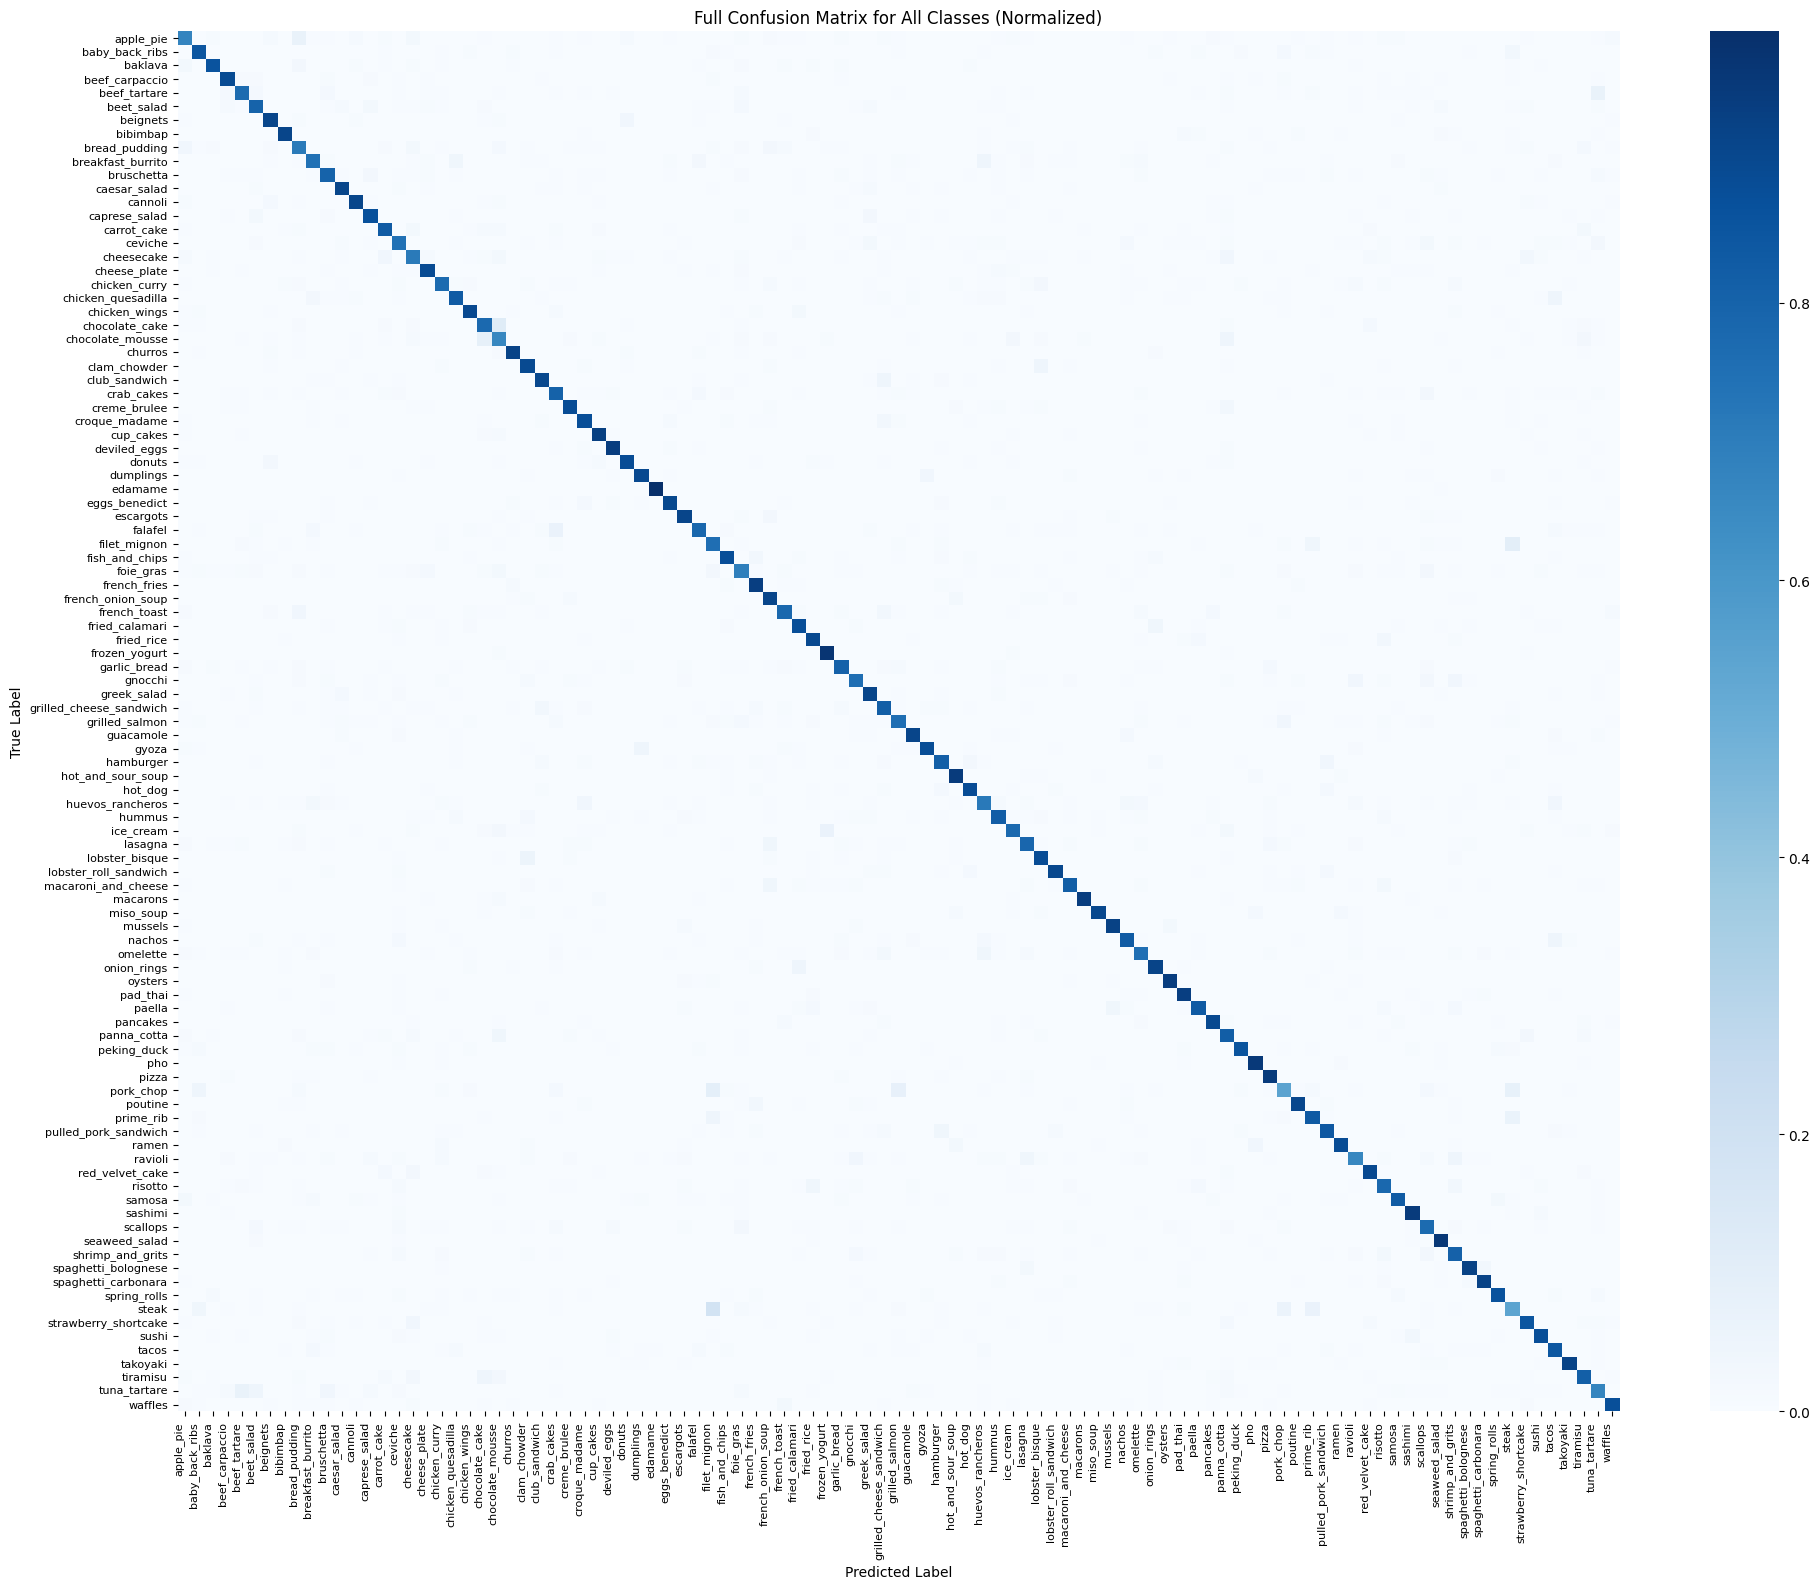

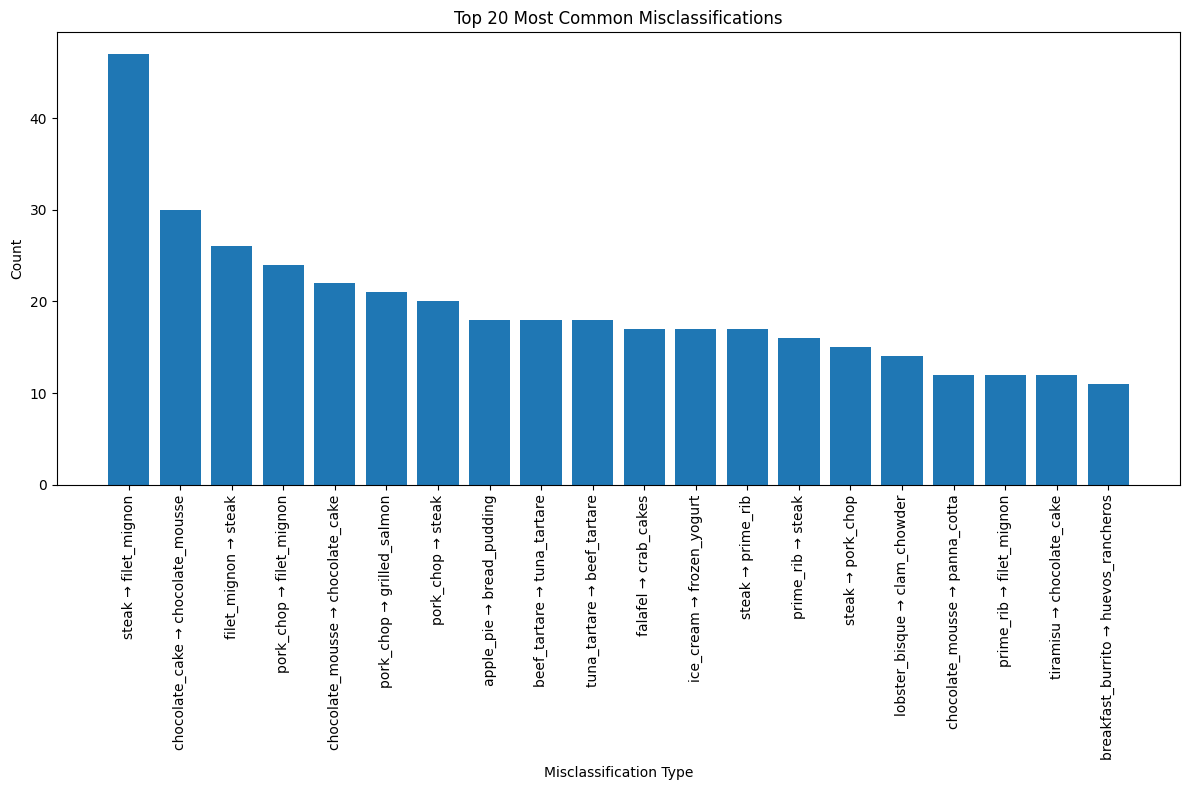


Training History Curves:


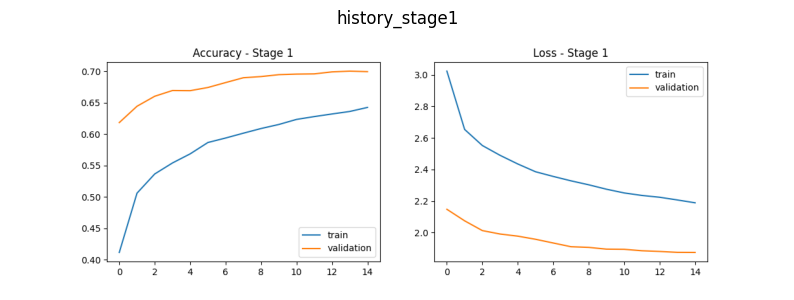

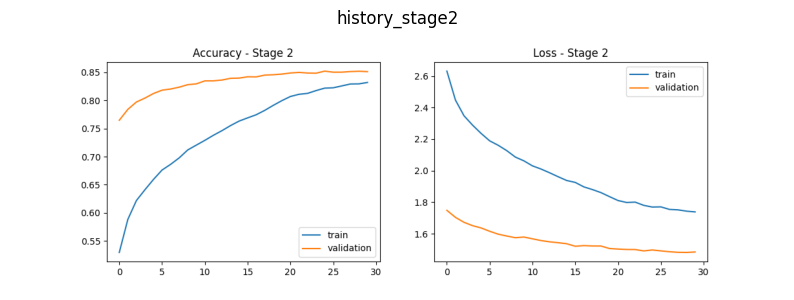


Evaluation completed successfully!


In [ ]:
# ============================================================
# Food-101 ResNet50 Model Evaluation Script
# ============================================================

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
from tqdm.notebook import tqdm

# ---------- Configuration ----------
OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Load Dataset ----------
print("Loading Food-101 dataset...")
dataset = load_dataset("ethz/food101")
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# ---------- Model Evaluation Function ----------
def manual_evaluate():
    """
    Perform comprehensive evaluation of the model on the Food-101 validation set

    This function:
    1. Loads the saved model
    2. Evaluates it on the validation set
    3. Calculates detailed metrics
    4. Generates visualizations
    5. Saves results to the output directory
    """
    # Load the saved inference model
    inference_model_path = f"{OUTPUT_DIR}/inference_model.keras"
    if not os.path.exists(inference_model_path):
        print(f"Inference model not found: {inference_model_path}")
        return

    print(f"Loading inference model: {inference_model_path}")
    model = tf.keras.models.load_model(inference_model_path)

    # ---------- Run Predictions ----------
    print("\nStarting evaluation...")

    # Setup for batch prediction
    batch_size = 16
    all_labels = []
    all_predictions = []
    validation_size = len(dataset['validation'])

    # Process validation set with progress tracking
    with tqdm(total=validation_size, desc="Evaluation Progress") as pbar:
        for i in range(0, validation_size, batch_size):
            # Get current batch range
            end_idx = min(i + batch_size, validation_size)
            current_batch_size = end_idx - i

            # Initialize batch containers
            batch_images = np.zeros((current_batch_size, 512, 512, 3), dtype=np.float32)
            batch_labels = np.zeros(current_batch_size, dtype=np.int32)

            # Process each image in the batch
            for j in range(current_batch_size):
                idx = i + j
                if idx >= validation_size:
                    break

                # Get and preprocess image
                item = dataset['validation'][idx]
                img = np.array(item['image'])

                # Handle different image formats
                if len(img.shape) == 2:  # Grayscale
                    img = np.stack([img]*3, axis=-1)
                elif img.shape[-1] == 4:  # RGBA
                    img = img[:, :, :3]  # Convert to RGB

                # Preprocess for model input
                img = tf.image.resize(img, (512, 512)).numpy()
                img = img / 255.0  # Normalize to [0,1]

                # Store in batch
                batch_images[j] = img
                batch_labels[j] = item['label']

            # Get model predictions
            predictions = model.predict(batch_images, verbose=0)
            pred_classes = np.argmax(predictions, axis=1)

            # Store results
            all_labels.extend(batch_labels)
            all_predictions.extend(pred_classes)

            # Update progress
            pbar.update(current_batch_size)

    # ---------- Calculate Metrics ----------
    print("\nCalculating metrics...")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Calculate per-class metrics
    per_class_precision = precision_score(all_labels, all_predictions, average=None)
    per_class_recall = recall_score(all_labels, all_predictions, average=None)
    per_class_f1 = f1_score(all_labels, all_predictions, average=None)

    # Calculate support per class
    unique_labels, label_counts = np.unique(all_labels, return_counts=True)
    per_class_support = np.zeros(num_classes, dtype=int)
    for i, count in zip(unique_labels, label_counts):
        per_class_support[i] = count

    # Create metrics DataFrame
    class_metrics = pd.DataFrame({
        'Class': food_classes,
        'Precision': per_class_precision.round(4),
        'Recall': per_class_recall.round(4),
        'F1-Score': per_class_f1.round(4),
        'Support': per_class_support
    })

    # Sort by recall (high to low)
    sorted_metrics = class_metrics.sort_values('Recall', ascending=False)

    # Calculate overall metrics
    accuracy = np.mean(np.array(all_labels) == np.array(all_predictions))
    precision_macro = precision_score(all_labels, all_predictions, average='macro')
    precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
    recall_macro = recall_score(all_labels, all_predictions, average='macro')
    recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

    # Create summary metrics DataFrame
    overall_metrics = pd.DataFrame([
        {'Class': 'accuracy', 'Precision': '', 'Recall': '', 'F1-Score': round(accuracy, 4), 'Support': len(all_labels)},
        {'Class': 'macro avg', 'Precision': round(precision_macro, 4), 'Recall': round(recall_macro, 4), 'F1-Score': round(f1_macro, 4), 'Support': len(all_labels)},
        {'Class': 'weighted avg', 'Precision': round(precision_weighted, 4), 'Recall': round(recall_weighted, 4), 'F1-Score': round(f1_weighted, 4), 'Support': len(all_labels)}
    ])

    # ---------- Display Results ----------
    # Print detailed metrics tables
    print("\nAll Classes Metrics (Sorted by Recall High to Low):")
    print(sorted_metrics.to_string(index=False))
    print("\n")
    print(overall_metrics.to_string(index=False))

    # Save metrics to CSV
    metrics_file = f"{OUTPUT_DIR}/class_metrics_by_recall.csv"
    pd.concat([sorted_metrics, overall_metrics]).to_csv(metrics_file, index=False)
    print(f"\nFull metrics table saved to: {metrics_file}")

    # ---------- Generate Visualizations ----------
    print("\nGenerating visualizations...")

    # 1. Class Recall Visualization
    plt.figure(figsize=(12, 20))
    sorted_by_recall = class_metrics.sort_values('Recall', ascending=False)
    plt.barh(sorted_by_recall['Class'], sorted_by_recall['Recall'], color='blue')
    plt.axvline(x=recall_macro, color='red', linestyle='--', label=f'Macro Avg: {recall_macro:.3f}')
    plt.title('Recall for All Classes (Sorted)')
    plt.xlabel('Recall')
    plt.ylabel('Class')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/all_recall.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Class Precision Visualization
    plt.figure(figsize=(12, 20))
    sorted_by_precision = class_metrics.sort_values('Precision', ascending=False)
    plt.barh(sorted_by_precision['Class'], sorted_by_precision['Precision'], color='green')
    plt.axvline(x=precision_macro, color='red', linestyle='--', label=f'Macro Avg: {precision_macro:.3f}')
    plt.title('Precision for All Classes (Sorted)')
    plt.xlabel('Precision')
    plt.ylabel('Class')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/all_precision.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Class F1-Score Visualization
    plt.figure(figsize=(12, 20))
    sorted_by_f1 = class_metrics.sort_values('F1-Score', ascending=False)
    plt.barh(sorted_by_f1['Class'], sorted_by_f1['F1-Score'], color='purple')
    plt.axvline(x=f1_macro, color='red', linestyle='--', label=f'Macro Avg: {f1_macro:.3f}')
    plt.title('F1 Scores for All Classes (Sorted)')
    plt.xlabel('F1 Score')
    plt.ylabel('Class')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/all_f1_scores.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Precision-Recall Scatter Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(per_class_precision, per_class_recall, alpha=0.6)

    # Annotate top and bottom performers
    top5_f1 = sorted_by_f1.head(5)  # Top 5 by F1 score
    bottom5_f1 = sorted_by_f1.tail(5)  # Bottom 5 by F1 score

    # Add labels to points
    for _, row in pd.concat([top5_f1, bottom5_f1]).iterrows():
        cls = row['Class']
        prec = row['Precision']
        rec = row['Recall']
        plt.annotate(cls, (prec, rec), fontsize=8)

    plt.xlim(0, 1.02)
    plt.ylim(0, 1.02)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall for All Classes')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/precision_recall_scatter.png", dpi=300)
    plt.show()

    # 5. F1-Score Distribution Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(per_class_f1, bins=20, alpha=0.7, color='purple')
    plt.axvline(f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro Avg F1: {f1_macro:.3f}')
    plt.title('F1 Score Distribution Across All Classes')
    plt.xlabel('F1 Score')
    plt.ylabel('Number of Classes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{OUTPUT_DIR}/f1_distribution.png", dpi=300)
    plt.show()

    # ---------- Confusion Matrix Analysis ----------
    # Save full confusion matrix to CSV
    cm_df = pd.DataFrame(cm, index=food_classes, columns=food_classes)
    cm_df.to_csv(f"{OUTPUT_DIR}/full_confusion_matrix.csv")
    print(f"Full confusion matrix saved to {OUTPUT_DIR}/full_confusion_matrix.csv")

    # Create normalized confusion matrix visualization
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 16))
    sns.heatmap(cm_norm, cmap="Blues", xticklabels=food_classes, yticklabels=food_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Full Confusion Matrix for All Classes (Normalized)')
    plt.xticks(rotation=90, ha="right", fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/full_confusion_matrix.png", dpi=300)
    plt.show()

    # ---------- Misclassification Analysis ----------
    # Remove diagonal elements (correct predictions)
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, 0)

    # Find and sort top misclassifications
    top_misclassifications = []
    for i in range(len(cm_copy)):
        for j in range(len(cm_copy)):
            if i != j and cm_copy[i, j] > 0:  # Only include errors
                top_misclassifications.append((i, j, cm_copy[i, j]))

    # Sort by count (descending) and take top 20
    top_misclassifications.sort(key=lambda x: x[2], reverse=True)
    top_misclassifications = top_misclassifications[:20]

    # Create DataFrame for misclassifications
    misclass_df = pd.DataFrame({
        'True Class': [food_classes[i] for i, j, _ in top_misclassifications],
        'Predicted Class': [food_classes[j] for i, j, _ in top_misclassifications],
        'Count': [count for _, _, count in top_misclassifications]
    })

    # Save to CSV
    misclass_df.to_csv(f"{OUTPUT_DIR}/top_misclassifications.csv", index=False)

    # Visualize top misclassifications
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(misclass_df)), misclass_df['Count'])
    plt.xticks(
        range(len(misclass_df)),
        [f"{true} → {pred}" for true, pred in zip(misclass_df['True Class'], misclass_df['Predicted Class'])],
        rotation=90
    )
    plt.xlabel('Misclassification Type')
    plt.ylabel('Count')
    plt.title('Top 20 Most Common Misclassifications')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/top_misclassifications.png", dpi=300)
    plt.show()

    # ---------- Training History Visualization ----------
    # Check if training history plots are available
    history_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png') and 'history' in f]
    if history_files:
        print("\nTraining History Curves:")
        for file in history_files:
            img = plt.imread(os.path.join(OUTPUT_DIR, file))
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(file.replace('.png', ''))
            plt.show()

    print("\nEvaluation completed successfully!")

# ---------- Run Evaluation ----------
if __name__ == "__main__":
    manual_evaluate()